# Medical Image Classification

In [24]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [25]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [26]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [27]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [28]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [29]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [30]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

In [8]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([891,  47, 232, 308, 457, 260, 742, 138,  99, 533])

In [16]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(10,10))
    plt.show()

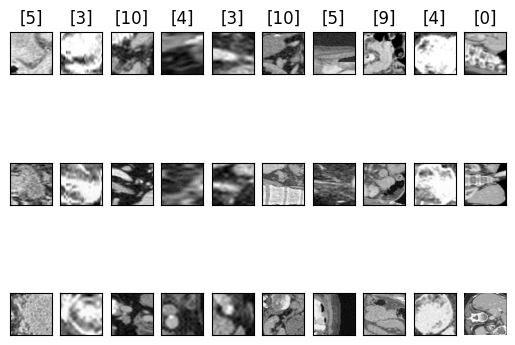

<Figure size 1000x1000 with 0 Axes>

In [18]:
show_slice(train_dataset_, idx)

In [10]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

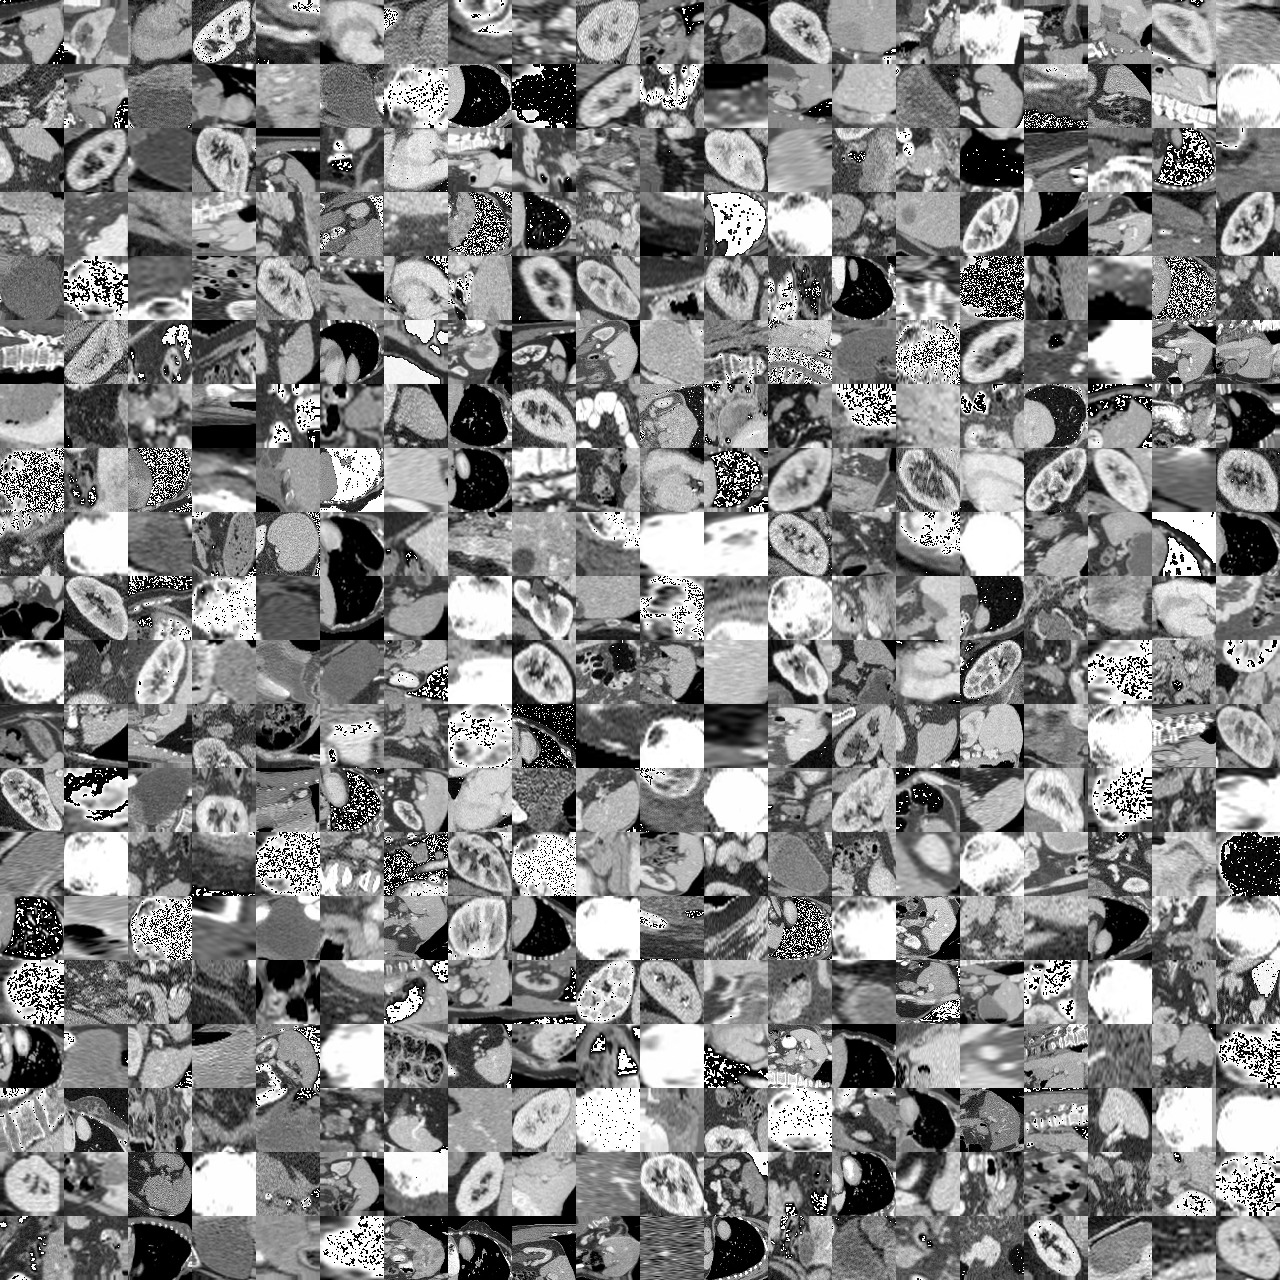

In [12]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

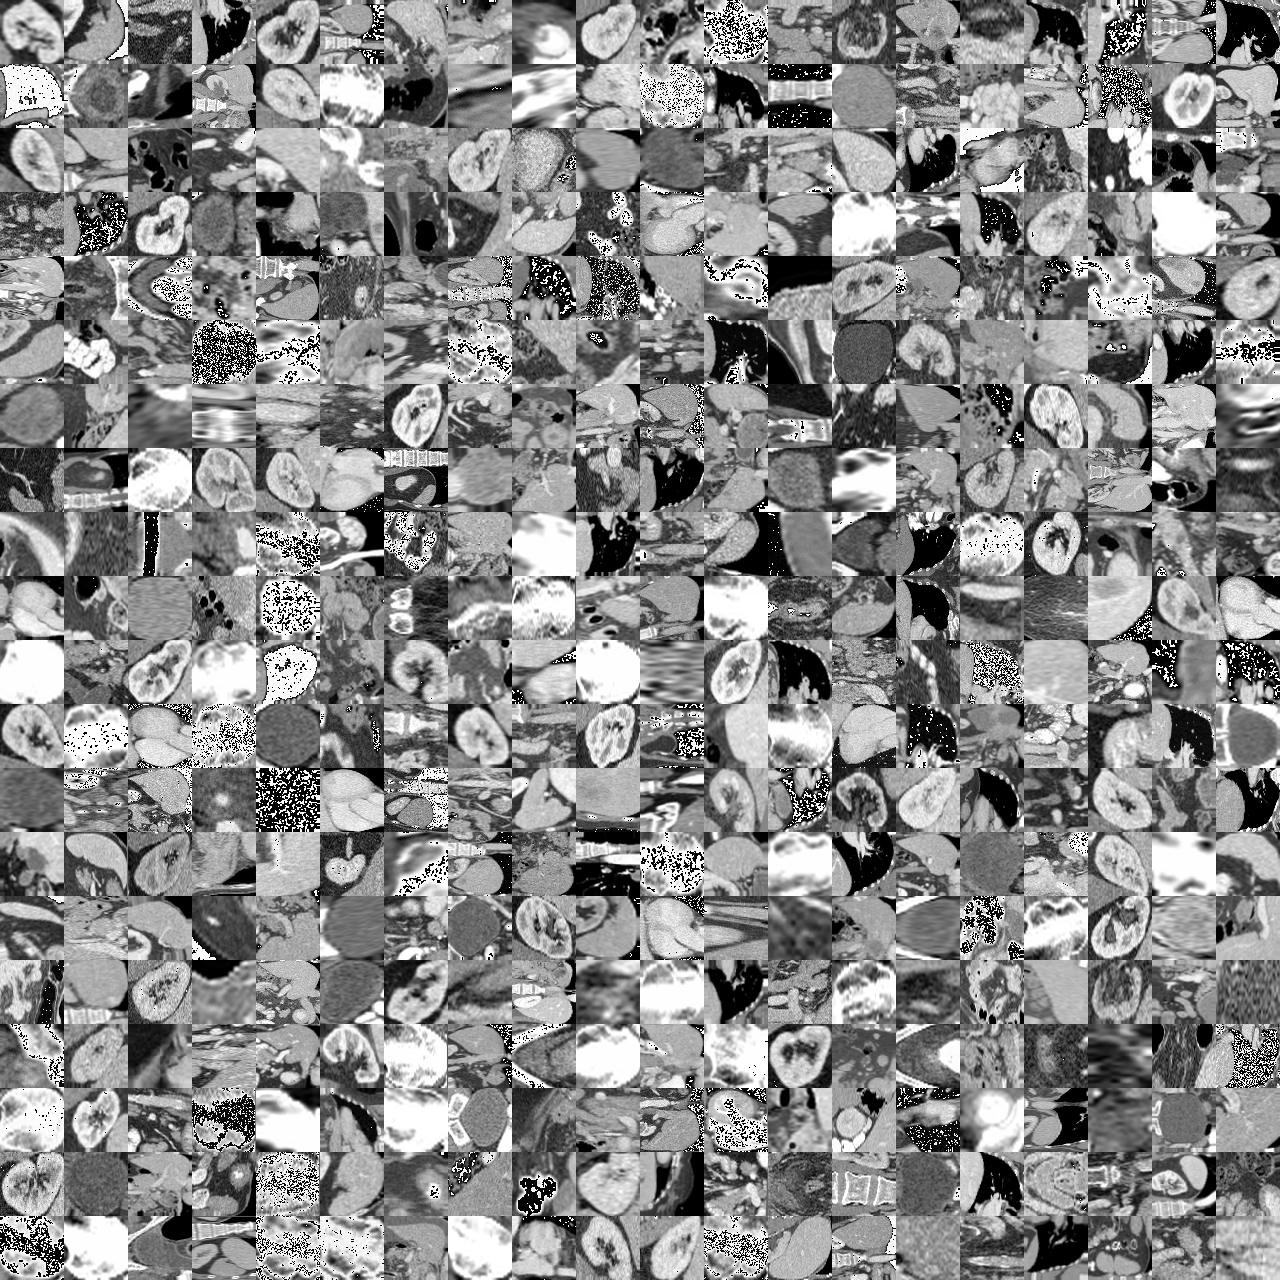

In [13]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

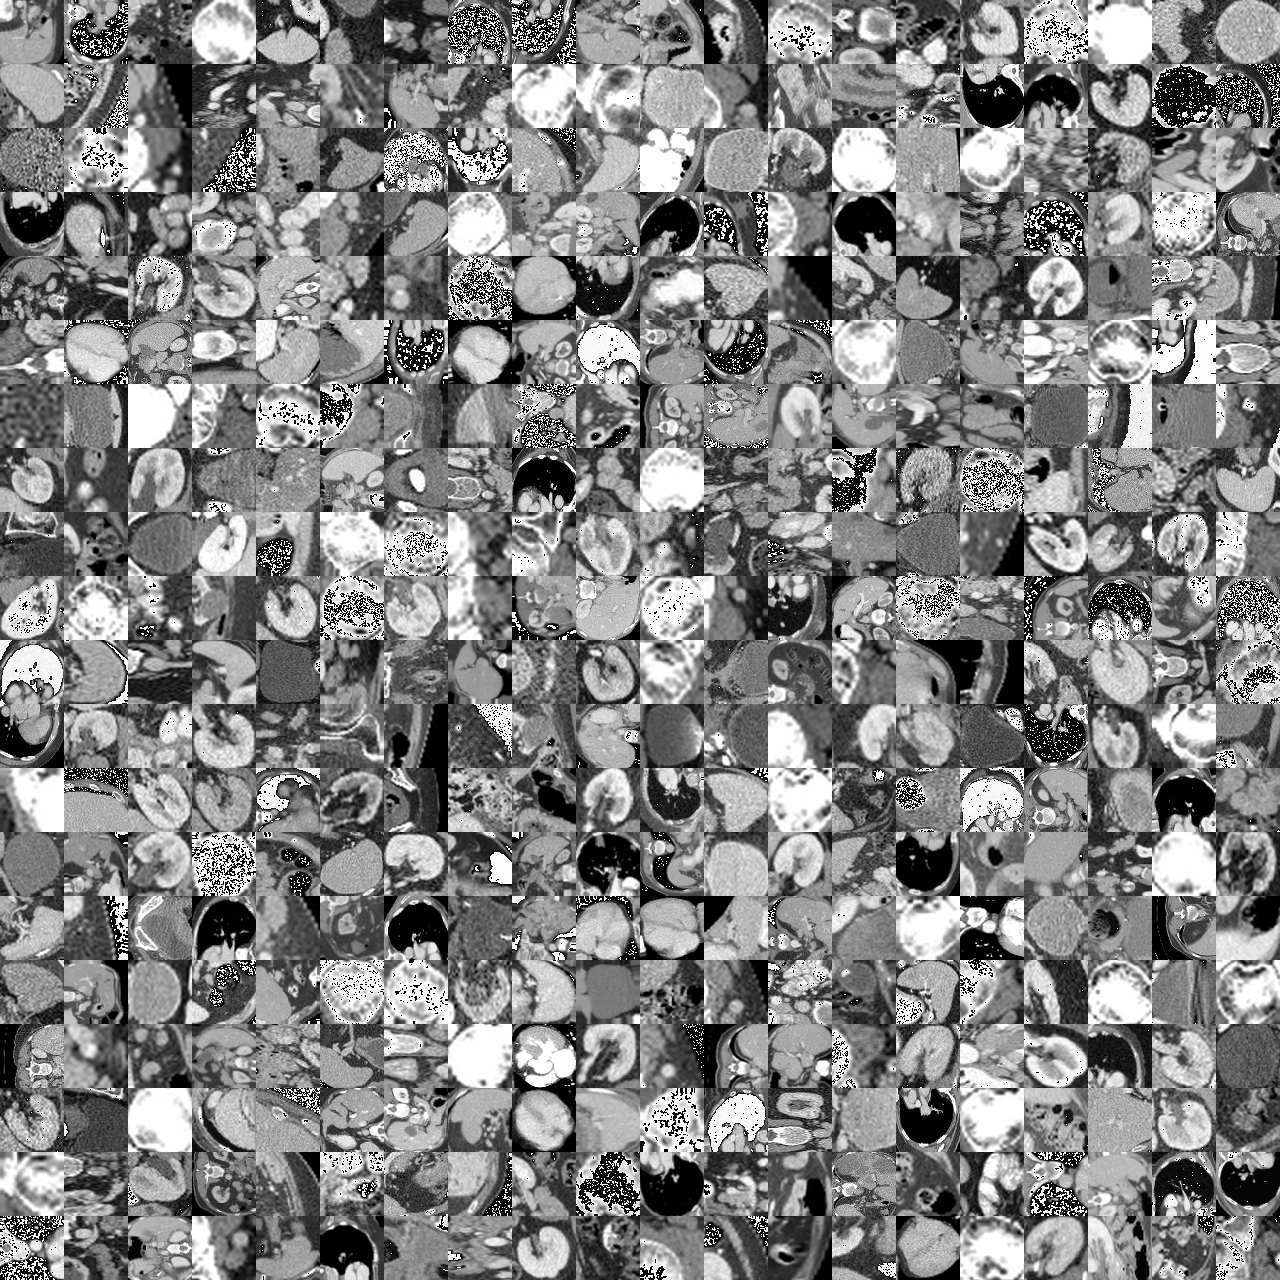

In [14]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

## Pretrained

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [32]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from tqdm import tqdm

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)

    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches: 100%|██████████| 31/31 [00:06<00:00,  5.13it/s, train_loss=1.58]
                                                                                  

epoch 1 average loss: 2.2135
1


Epochs:   1%|          | 1/100 [00:07<12:40,  7.68s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6894 current accuracy: 0.1988 best AUC: 0.6894 at epoch: 1
----------
epoch 2/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.50it/s, train_loss=1.27]
                                                                                  

epoch 2 average loss: 1.4064
1


Epochs:   2%|▏         | 2/100 [00:15<12:18,  7.53s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9634 current accuracy: 0.6584 best AUC: 0.9634 at epoch: 2
----------
epoch 3/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=1.12]
                                                                                  

epoch 3 average loss: 1.1360
1


Epochs:   3%|▎         | 3/100 [00:22<12:07,  7.50s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9739 current accuracy: 0.7329 best AUC: 0.9739 at epoch: 3
----------
epoch 4/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=1.04] 
                                                                                  

epoch 4 average loss: 1.0006
1


Epochs:   4%|▍         | 4/100 [00:30<11:58,  7.49s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9773 current accuracy: 0.7516 best AUC: 0.9773 at epoch: 4
----------
epoch 5/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.688]
                                                                                   

epoch 5 average loss: 0.8317
1


Epochs:   5%|▌         | 5/100 [00:37<11:52,  7.50s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9783 current accuracy: 0.7391 best AUC: 0.9783 at epoch: 5
----------
epoch 6/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=1.23] 
                                                                                  

epoch 6 average loss: 0.7822
1


Epochs:   6%|▌         | 6/100 [00:45<11:45,  7.51s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9795 current accuracy: 0.7205 best AUC: 0.9795 at epoch: 6
----------
epoch 7/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.441]
                                                                                   

epoch 7 average loss: 0.6837
1


Epochs:   7%|▋         | 7/100 [00:52<11:41,  7.54s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9801 current accuracy: 0.7702 best AUC: 0.9801 at epoch: 7
----------
epoch 8/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.587]
                                                                                   

epoch 8 average loss: 0.6248
1


Epochs:   8%|▊         | 8/100 [01:00<11:32,  7.53s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9818 current accuracy: 0.7702 best AUC: 0.9818 at epoch: 8
----------
epoch 9/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.444]
                                                                                   

epoch 9 average loss: 0.5616
1


Epochs:   9%|▉         | 9/100 [01:07<11:25,  7.53s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9829 current accuracy: 0.7764 best AUC: 0.9829 at epoch: 9
----------
epoch 10/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.269]
                                                                                   

epoch 10 average loss: 0.4991
1


Epochs:  10%|█         | 10/100 [01:15<11:17,  7.53s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9849 current accuracy: 0.8137 best AUC: 0.9849 at epoch: 10
----------
epoch 11/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.461]
                                                                                   

epoch 11 average loss: 0.4800


Epochs:  11%|█         | 11/100 [01:22<11:01,  7.43s/it]

1
current epoch: 11 current AUC: 0.9841 current accuracy: 0.8012 best AUC: 0.9849 at epoch: 10
----------
epoch 12/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.85] 
                                                                                  

epoch 12 average loss: 0.4494


Epochs:  12%|█▏        | 12/100 [01:29<10:47,  7.36s/it]

1
current epoch: 12 current AUC: 0.9839 current accuracy: 0.7826 best AUC: 0.9849 at epoch: 10
----------
epoch 13/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.454]
                                                                                   

epoch 13 average loss: 0.4027
1


Epochs:  13%|█▎        | 13/100 [01:37<10:47,  7.44s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9863 current accuracy: 0.7950 best AUC: 0.9863 at epoch: 13
----------
epoch 14/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.665]
                                                                                   

epoch 14 average loss: 0.3673


Epochs:  14%|█▍        | 14/100 [01:44<10:32,  7.35s/it]

1
current epoch: 14 current AUC: 0.9838 current accuracy: 0.7950 best AUC: 0.9863 at epoch: 13
----------
epoch 15/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.464]
                                                                                   

epoch 15 average loss: 0.3734


Epochs:  15%|█▌        | 15/100 [01:51<10:19,  7.28s/it]

1
current epoch: 15 current AUC: 0.9855 current accuracy: 0.7950 best AUC: 0.9863 at epoch: 13
----------
epoch 16/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.50it/s, train_loss=1.24] 
                                                                                  

epoch 16 average loss: 0.3807


Epochs:  16%|█▌        | 16/100 [01:58<10:06,  7.23s/it]

1
current epoch: 16 current AUC: 0.9848 current accuracy: 0.8012 best AUC: 0.9863 at epoch: 13
----------
epoch 17/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.594]
                                                                                   

epoch 17 average loss: 0.3238
1


Epochs:  17%|█▋        | 17/100 [02:06<10:06,  7.31s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9864 current accuracy: 0.8199 best AUC: 0.9864 at epoch: 17
----------
epoch 18/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.44it/s, train_loss=0.351]
                                                                                   

epoch 18 average loss: 0.2704
1


Epochs:  18%|█▊        | 18/100 [02:14<10:12,  7.47s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9865 current accuracy: 0.7950 best AUC: 0.9865 at epoch: 18
----------
epoch 19/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.547]
                                                                                   

epoch 19 average loss: 0.2915


Epochs:  19%|█▉        | 19/100 [02:21<09:59,  7.40s/it]

1
current epoch: 19 current AUC: 0.9855 current accuracy: 0.8075 best AUC: 0.9865 at epoch: 18
----------
epoch 20/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.241]
                                                                                   

epoch 20 average loss: 0.2623


Epochs:  20%|██        | 20/100 [02:28<09:46,  7.33s/it]

1
current epoch: 20 current AUC: 0.9864 current accuracy: 0.7950 best AUC: 0.9865 at epoch: 18
----------
epoch 21/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.24] 
                                                                                  

epoch 21 average loss: 0.2345
1


Epochs:  21%|██        | 21/100 [02:36<09:45,  7.41s/it]

saved new best metric model
current epoch: 21 current AUC: 0.9869 current accuracy: 0.8199 best AUC: 0.9869 at epoch: 21
----------
epoch 22/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=1.01] 
                                                                                  

epoch 22 average loss: 0.2462
1


Epochs:  22%|██▏       | 22/100 [02:43<09:42,  7.47s/it]

saved new best metric model
current epoch: 22 current AUC: 0.9887 current accuracy: 0.8137 best AUC: 0.9887 at epoch: 22
----------
epoch 23/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=1.69] 
                                                                                  

epoch 23 average loss: 0.2453


Epochs:  23%|██▎       | 23/100 [02:50<09:29,  7.39s/it]

1
current epoch: 23 current AUC: 0.9870 current accuracy: 0.7950 best AUC: 0.9887 at epoch: 22
----------
epoch 24/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.503]
                                                                                   

epoch 24 average loss: 0.2173


Epochs:  24%|██▍       | 24/100 [02:57<09:16,  7.32s/it]

1
current epoch: 24 current AUC: 0.9860 current accuracy: 0.8137 best AUC: 0.9887 at epoch: 22
----------
epoch 25/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.52it/s, train_loss=1.16] 
                                                                                  

epoch 25 average loss: 0.2354
1


Epochs:  25%|██▌       | 25/100 [03:05<09:14,  7.40s/it]

saved new best metric model
current epoch: 25 current AUC: 0.9901 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 26/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.48] 
                                                                                  

epoch 26 average loss: 0.1860


Epochs:  26%|██▌       | 26/100 [03:12<09:01,  7.32s/it]

1
current epoch: 26 current AUC: 0.9859 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 27/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.31it/s, train_loss=0.229]
                                                                                   

epoch 27 average loss: 0.2051


Epochs:  27%|██▋       | 27/100 [03:19<08:52,  7.29s/it]

1
current epoch: 27 current AUC: 0.9867 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 28/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.175]
                                                                                   

epoch 28 average loss: 0.1602


Epochs:  28%|██▊       | 28/100 [03:27<08:44,  7.28s/it]

1
current epoch: 28 current AUC: 0.9854 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 29/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.166]
                                                                                   

epoch 29 average loss: 0.1664


Epochs:  29%|██▉       | 29/100 [03:34<08:35,  7.27s/it]

1
current epoch: 29 current AUC: 0.9852 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 30/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.36it/s, train_loss=0.828]
                                                                                   

epoch 30 average loss: 0.1666


Epochs:  30%|███       | 30/100 [03:41<08:26,  7.23s/it]

1
current epoch: 30 current AUC: 0.9852 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 31/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.421] 
                                                                                   

epoch 31 average loss: 0.1659


Epochs:  31%|███       | 31/100 [03:48<08:17,  7.21s/it]

1
current epoch: 31 current AUC: 0.9883 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 32/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.312] 
                                                                                   

epoch 32 average loss: 0.1368


Epochs:  32%|███▏      | 32/100 [03:55<08:10,  7.21s/it]

1
current epoch: 32 current AUC: 0.9860 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 33/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.671] 
                                                                                   

epoch 33 average loss: 0.1419


Epochs:  33%|███▎      | 33/100 [04:03<08:02,  7.20s/it]

1
current epoch: 33 current AUC: 0.9881 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 34/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.38it/s, train_loss=0.343]
                                                                                   

epoch 34 average loss: 0.1585


Epochs:  34%|███▍      | 34/100 [04:10<07:56,  7.22s/it]

1
current epoch: 34 current AUC: 0.9840 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 35/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.0633]
                                                                                    

epoch 35 average loss: 0.1418


Epochs:  35%|███▌      | 35/100 [04:17<07:49,  7.22s/it]

1
current epoch: 35 current AUC: 0.9839 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 36/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.49it/s, train_loss=0.104]
                                                                                   

epoch 36 average loss: 0.1494


Epochs:  36%|███▌      | 36/100 [04:24<07:40,  7.20s/it]

1
current epoch: 36 current AUC: 0.9830 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 37/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.898]
                                                                                   

epoch 37 average loss: 0.1669


Epochs:  37%|███▋      | 37/100 [04:31<07:33,  7.19s/it]

1
current epoch: 37 current AUC: 0.9844 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 38/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.38it/s, train_loss=0.132]
                                                                                   

epoch 38 average loss: 0.1263


Epochs:  38%|███▊      | 38/100 [04:39<07:28,  7.24s/it]

1
current epoch: 38 current AUC: 0.9828 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 39/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.32it/s, train_loss=0.33] 
                                                                                  

epoch 39 average loss: 0.1192


Epochs:  39%|███▉      | 39/100 [04:46<07:21,  7.24s/it]

1
current epoch: 39 current AUC: 0.9846 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 40/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.246]
                                                                                   

epoch 40 average loss: 0.1274


Epochs:  40%|████      | 40/100 [04:53<07:12,  7.22s/it]

1
current epoch: 40 current AUC: 0.9849 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 41/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.36it/s, train_loss=0.386]
                                                                                   

epoch 41 average loss: 0.1423


Epochs:  41%|████      | 41/100 [05:00<07:06,  7.23s/it]

1
current epoch: 41 current AUC: 0.9831 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 42/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.0933]
                                                                                    

epoch 42 average loss: 0.1283


Epochs:  42%|████▏     | 42/100 [05:08<06:58,  7.22s/it]

1
current epoch: 42 current AUC: 0.9835 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 43/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.323] 
                                                                                   

epoch 43 average loss: 0.1020


Epochs:  43%|████▎     | 43/100 [05:15<06:50,  7.21s/it]

1
current epoch: 43 current AUC: 0.9837 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 44/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.0806]
                                                                                    

epoch 44 average loss: 0.0946


Epochs:  44%|████▍     | 44/100 [05:22<06:42,  7.19s/it]

1
current epoch: 44 current AUC: 0.9842 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 45/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.343] 
                                                                                   

epoch 45 average loss: 0.1123


Epochs:  45%|████▌     | 45/100 [05:29<06:36,  7.21s/it]

1
current epoch: 45 current AUC: 0.9848 current accuracy: 0.8385 best AUC: 0.9901 at epoch: 25
----------
epoch 46/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.54it/s, train_loss=0.474] 
                                                                                   

epoch 46 average loss: 0.1003


Epochs:  46%|████▌     | 46/100 [05:36<06:28,  7.20s/it]

1
current epoch: 46 current AUC: 0.9819 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 47/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.36it/s, train_loss=0.158] 
                                                                                   

epoch 47 average loss: 0.1240


Epochs:  47%|████▋     | 47/100 [05:44<06:22,  7.21s/it]

1
current epoch: 47 current AUC: 0.9832 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 48/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=0.23] 
                                                                                  

epoch 48 average loss: 0.0984


Epochs:  48%|████▊     | 48/100 [05:51<06:14,  7.21s/it]

1
current epoch: 48 current AUC: 0.9852 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 49/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=0.108] 
                                                                                   

epoch 49 average loss: 0.0801


Epochs:  49%|████▉     | 49/100 [05:58<06:08,  7.22s/it]

1
current epoch: 49 current AUC: 0.9872 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 50/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.0444]
                                                                                    

epoch 50 average loss: 0.0733


Epochs:  50%|█████     | 50/100 [06:05<05:59,  7.20s/it]

1
current epoch: 50 current AUC: 0.9871 current accuracy: 0.8571 best AUC: 0.9901 at epoch: 25
----------
epoch 51/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.23it/s, train_loss=0.0145]
                                                                                    

epoch 51 average loss: 0.0920


Epochs:  51%|█████     | 51/100 [06:12<05:53,  7.22s/it]

1
current epoch: 51 current AUC: 0.9859 current accuracy: 0.8634 best AUC: 0.9901 at epoch: 25
----------
epoch 52/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.00947]
                                                                                     

epoch 52 average loss: 0.0938


Epochs:  52%|█████▏    | 52/100 [06:20<05:45,  7.20s/it]

1
current epoch: 52 current AUC: 0.9866 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 53/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.0608]
                                                                                    

epoch 53 average loss: 0.0890


Epochs:  53%|█████▎    | 53/100 [06:27<05:39,  7.22s/it]

1
current epoch: 53 current AUC: 0.9827 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 54/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.22it/s, train_loss=0.559] 
                                                                                   

epoch 54 average loss: 0.0939


Epochs:  54%|█████▍    | 54/100 [06:34<05:32,  7.23s/it]

1
current epoch: 54 current AUC: 0.9841 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 55/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.0947]
                                                                                    

epoch 55 average loss: 0.0845


Epochs:  55%|█████▌    | 55/100 [06:41<05:24,  7.22s/it]

1
current epoch: 55 current AUC: 0.9870 current accuracy: 0.8571 best AUC: 0.9901 at epoch: 25
----------
epoch 56/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.102]
                                                                                   

epoch 56 average loss: 0.0906


Epochs:  56%|█████▌    | 56/100 [06:49<05:17,  7.23s/it]

1
current epoch: 56 current AUC: 0.9862 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 25
----------
epoch 57/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.32it/s, train_loss=0.0283]
                                                                                    

epoch 57 average loss: 0.0704


Epochs:  57%|█████▋    | 57/100 [06:56<05:11,  7.24s/it]

1
current epoch: 57 current AUC: 0.9846 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 58/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.509] 
                                                                                   

epoch 58 average loss: 0.0847


Epochs:  58%|█████▊    | 58/100 [07:03<05:04,  7.24s/it]

1
current epoch: 58 current AUC: 0.9843 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 59/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.40it/s, train_loss=0.143] 
                                                                                   

epoch 59 average loss: 0.0771


Epochs:  59%|█████▉    | 59/100 [07:10<04:57,  7.26s/it]

1
current epoch: 59 current AUC: 0.9840 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 60/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.347] 
                                                                                   

epoch 60 average loss: 0.0972


Epochs:  60%|██████    | 60/100 [07:18<04:49,  7.25s/it]

1
current epoch: 60 current AUC: 0.9863 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 61/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.312] 
                                                                                   

epoch 61 average loss: 0.0926


Epochs:  61%|██████    | 61/100 [07:25<04:42,  7.24s/it]

1
current epoch: 61 current AUC: 0.9862 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 62/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.173] 
                                                                                   

epoch 62 average loss: 0.0773


Epochs:  62%|██████▏   | 62/100 [07:32<04:34,  7.23s/it]

1
current epoch: 62 current AUC: 0.9858 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 63/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.0837]
                                                                                    

epoch 63 average loss: 0.0614


Epochs:  63%|██████▎   | 63/100 [07:39<04:26,  7.20s/it]

1
current epoch: 63 current AUC: 0.9820 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 64/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.0136]
                                                                                    

epoch 64 average loss: 0.0681


Epochs:  64%|██████▍   | 64/100 [07:46<04:19,  7.20s/it]

1
current epoch: 64 current AUC: 0.9862 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 65/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.0107]
                                                                                    

epoch 65 average loss: 0.0562


Epochs:  65%|██████▌   | 65/100 [07:54<04:12,  7.20s/it]

1
current epoch: 65 current AUC: 0.9838 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 66/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.39]  
                                                                                  

epoch 66 average loss: 0.0649


Epochs:  66%|██████▌   | 66/100 [08:01<04:04,  7.21s/it]

1
current epoch: 66 current AUC: 0.9852 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 67/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.124] 
                                                                                   

epoch 67 average loss: 0.0653


Epochs:  67%|██████▋   | 67/100 [08:08<03:57,  7.19s/it]

1
current epoch: 67 current AUC: 0.9851 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 68/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.849] 
                                                                                   

epoch 68 average loss: 0.0864


Epochs:  68%|██████▊   | 68/100 [08:15<03:49,  7.17s/it]

1
current epoch: 68 current AUC: 0.9844 current accuracy: 0.8509 best AUC: 0.9901 at epoch: 25
----------
epoch 69/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.0799]
                                                                                    

epoch 69 average loss: 0.0857


Epochs:  69%|██████▉   | 69/100 [08:22<03:42,  7.18s/it]

1
current epoch: 69 current AUC: 0.9846 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 70/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.502]
                                                                                   

epoch 70 average loss: 0.0970


Epochs:  70%|███████   | 70/100 [08:30<03:35,  7.20s/it]

1
current epoch: 70 current AUC: 0.9841 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 71/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  3.82it/s, train_loss=0.052] 
                                                                                   

epoch 71 average loss: 0.0725


Epochs:  71%|███████   | 71/100 [08:37<03:34,  7.38s/it]

1
current epoch: 71 current AUC: 0.9813 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 72/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.63it/s, train_loss=0.0939]
                                                                                    

epoch 72 average loss: 0.0604


Epochs:  72%|███████▏  | 72/100 [08:45<03:24,  7.32s/it]

1
current epoch: 72 current AUC: 0.9818 current accuracy: 0.8075 best AUC: 0.9901 at epoch: 25
----------
epoch 73/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.18it/s, train_loss=0.256] 
                                                                                   

epoch 73 average loss: 0.0695


Epochs:  73%|███████▎  | 73/100 [08:53<03:25,  7.59s/it]

1
current epoch: 73 current AUC: 0.9844 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 74/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.27it/s, train_loss=0.0552]
                                                                                    

epoch 74 average loss: 0.0765


Epochs:  74%|███████▍  | 74/100 [09:00<03:14,  7.49s/it]

1
current epoch: 74 current AUC: 0.9828 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 75/100



Training Batches: 100%|██████████| 31/31 [00:07<00:00,  5.07it/s, train_loss=0.317]
                                                                                   

epoch 75 average loss: 0.0782


Epochs:  75%|███████▌  | 75/100 [09:07<03:06,  7.48s/it]

1
current epoch: 75 current AUC: 0.9784 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 76/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.20it/s, train_loss=1.39]  
                                                                                  

epoch 76 average loss: 0.1237


Epochs:  76%|███████▌  | 76/100 [09:16<03:10,  7.93s/it]

1
current epoch: 76 current AUC: 0.9798 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 77/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.45it/s, train_loss=0.408]
                                                                                   

epoch 77 average loss: 0.1113


Epochs:  77%|███████▋  | 77/100 [09:24<02:58,  7.74s/it]

1
current epoch: 77 current AUC: 0.9789 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 78/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.31it/s, train_loss=0.188]
                                                                                   

epoch 78 average loss: 0.0755


Epochs:  78%|███████▊  | 78/100 [09:32<02:52,  7.82s/it]

1
current epoch: 78 current AUC: 0.9781 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 79/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.264] 
                                                                                   

epoch 79 average loss: 0.0631


Epochs:  79%|███████▉  | 79/100 [09:39<02:40,  7.65s/it]

1
current epoch: 79 current AUC: 0.9779 current accuracy: 0.8137 best AUC: 0.9901 at epoch: 25
----------
epoch 80/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.28it/s, train_loss=0.116] 
                                                                                   

epoch 80 average loss: 0.0926


Epochs:  80%|████████  | 80/100 [09:48<02:39,  8.00s/it]

1
current epoch: 80 current AUC: 0.9799 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 81/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.31it/s, train_loss=0.56] 
                                                                                  

epoch 81 average loss: 0.0692


Epochs:  81%|████████  | 81/100 [09:56<02:34,  8.15s/it]

1
current epoch: 81 current AUC: 0.9805 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 82/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.0164]
                                                                                    

epoch 82 average loss: 0.0717


Epochs:  82%|████████▏ | 82/100 [10:04<02:21,  7.87s/it]

1
current epoch: 82 current AUC: 0.9800 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 83/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.30it/s, train_loss=0.172] 
                                                                                   

epoch 83 average loss: 0.0582


Epochs:  83%|████████▎ | 83/100 [10:11<02:10,  7.68s/it]

1
current epoch: 83 current AUC: 0.9781 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 84/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.30it/s, train_loss=0.105]
                                                                                   

epoch 84 average loss: 0.0723


Epochs:  84%|████████▍ | 84/100 [10:18<02:00,  7.53s/it]

1
current epoch: 84 current AUC: 0.9786 current accuracy: 0.8012 best AUC: 0.9901 at epoch: 25
----------
epoch 85/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.45it/s, train_loss=0.036]
                                                                                   

epoch 85 average loss: 0.0723


Epochs:  85%|████████▌ | 85/100 [10:26<01:57,  7.81s/it]

1
current epoch: 85 current AUC: 0.9816 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 86/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.36it/s, train_loss=0.051] 
                                                                                   

epoch 86 average loss: 0.0496


Epochs:  86%|████████▌ | 86/100 [10:34<01:46,  7.63s/it]

1
current epoch: 86 current AUC: 0.9803 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 25
----------
epoch 87/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.00191]
                                                                                     

epoch 87 average loss: 0.0292


Epochs:  87%|████████▋ | 87/100 [10:41<01:37,  7.50s/it]

1
current epoch: 87 current AUC: 0.9813 current accuracy: 0.8571 best AUC: 0.9901 at epoch: 25
----------
epoch 88/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.204] 
                                                                                   

epoch 88 average loss: 0.0529


Epochs:  88%|████████▊ | 88/100 [10:48<01:29,  7.43s/it]

1
current epoch: 88 current AUC: 0.9776 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 25
----------
epoch 89/100



Training Batches: 100%|██████████| 31/31 [00:06<00:00,  5.08it/s, train_loss=0.0112]
                                                                                    

epoch 89 average loss: 0.0544


Epochs:  89%|████████▉ | 89/100 [10:55<01:21,  7.38s/it]

1
current epoch: 89 current AUC: 0.9827 current accuracy: 0.8634 best AUC: 0.9901 at epoch: 25
----------
epoch 90/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.43it/s, train_loss=0.12]  
                                                                                  

epoch 90 average loss: 0.0505


Epochs:  90%|█████████ | 90/100 [11:03<01:13,  7.37s/it]

1
current epoch: 90 current AUC: 0.9820 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 25
----------
epoch 91/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.40it/s, train_loss=0.0613]
                                                                                    

epoch 91 average loss: 0.0490


Epochs:  91%|█████████ | 91/100 [11:11<01:08,  7.64s/it]

1
current epoch: 91 current AUC: 0.9787 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 92/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.29it/s, train_loss=0.193] 
                                                                                   

epoch 92 average loss: 0.0625


Epochs:  92%|█████████▏| 92/100 [11:18<01:00,  7.53s/it]

1
current epoch: 92 current AUC: 0.9832 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 93/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.30it/s, train_loss=0.0629]
                                                                                    

epoch 93 average loss: 0.0564


Epochs:  93%|█████████▎| 93/100 [11:25<00:52,  7.45s/it]

1
current epoch: 93 current AUC: 0.9796 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 94/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.20it/s, train_loss=0.0567]
                                                                                    

epoch 94 average loss: 0.0455


Epochs:  94%|█████████▍| 94/100 [11:34<00:46,  7.75s/it]

1
current epoch: 94 current AUC: 0.9817 current accuracy: 0.8634 best AUC: 0.9901 at epoch: 25
----------
epoch 95/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.44it/s, train_loss=0.33]  
                                                                                  

epoch 95 average loss: 0.0496


Epochs:  95%|█████████▌| 95/100 [11:42<00:38,  7.73s/it]

1
current epoch: 95 current AUC: 0.9820 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 25
----------
epoch 96/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  3.78it/s, train_loss=0.0363]
                                                                                    

epoch 96 average loss: 0.0431


Epochs:  96%|█████████▌| 96/100 [11:50<00:31,  7.87s/it]

1
current epoch: 96 current AUC: 0.9804 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
----------
epoch 97/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.0187]
                                                                                    

epoch 97 average loss: 0.0442


Epochs:  97%|█████████▋| 97/100 [11:57<00:22,  7.64s/it]

1
current epoch: 97 current AUC: 0.9761 current accuracy: 0.8199 best AUC: 0.9901 at epoch: 25
----------
epoch 98/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.0683]
                                                                                    

epoch 98 average loss: 0.0591


Epochs:  98%|█████████▊| 98/100 [12:04<00:14,  7.49s/it]

1
current epoch: 98 current AUC: 0.9805 current accuracy: 0.8261 best AUC: 0.9901 at epoch: 25
----------
epoch 99/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.225]
                                                                                   

epoch 99 average loss: 0.0448


Epochs:  99%|█████████▉| 99/100 [12:11<00:07,  7.41s/it]

1
current epoch: 99 current AUC: 0.9839 current accuracy: 0.8385 best AUC: 0.9901 at epoch: 25
----------
epoch 100/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.21it/s, train_loss=0.046] 
                                                                                   

epoch 100 average loss: 0.0462


Epochs: 100%|██████████| 100/100 [12:19<00:00,  7.40s/it]

1
current epoch: 100 current AUC: 0.9838 current accuracy: 0.8323 best AUC: 0.9901 at epoch: 25
train completed, best_metric: 0.9901 at epoch: 25


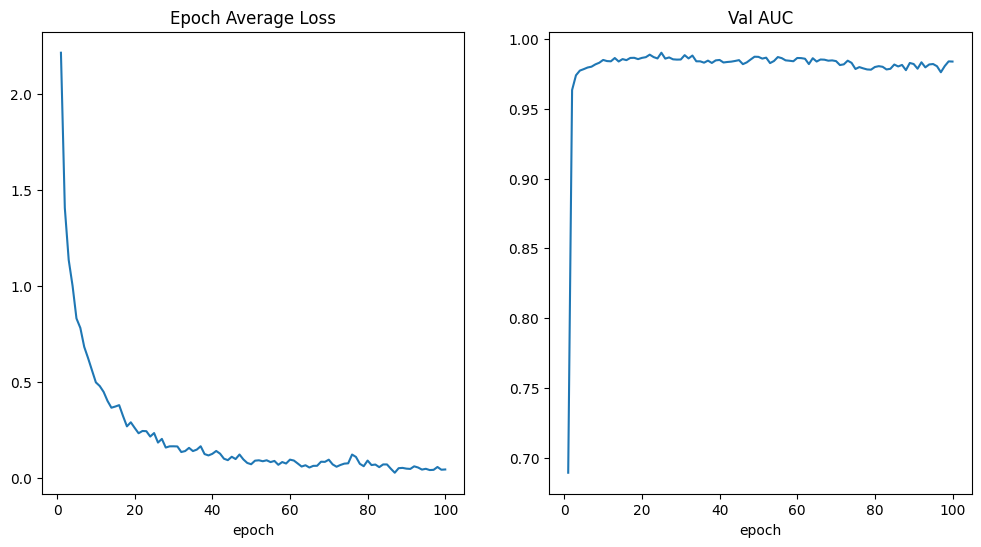

In [34]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [35]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [36]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9155    0.9420    0.9286        69
           1     0.4638    0.4706    0.4672        68
           2     0.5397    0.4928    0.5152        69
           3     0.4394    0.4462    0.4427        65
           4     0.3966    0.3538    0.3740        65
           5     0.7237    0.8333    0.7746        66
           6     0.8000    0.7143    0.7547        28
           7     1.0000    0.9048    0.9500        21
           8     0.9130    1.0000    0.9545        21
           9     0.6410    0.7246    0.6803        69
          10     0.6774    0.6087    0.6412        69

    accuracy                         0.6393       610
   macro avg     0.6827    0.6810    0.6803       610
weighted avg     0.6354    0.6393    0.6359       610



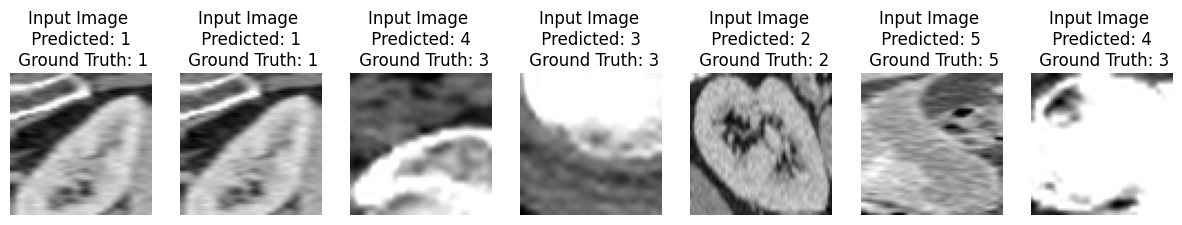

In [37]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [23]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()


Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.66it/s, train_loss=0.612]
                                                                                   

epoch 12 average loss: 0.6761
1


Epochs:  12%|█▏        | 12/100 [01:26<10:18,  7.03s/it]

current epoch: 12 current AUC: 0.9852 current accuracy: 0.7391 best AUC: 0.9867 at epoch: 11
----------
epoch 13/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.63it/s, train_loss=0.527]
                                                                                   

epoch 13 average loss: 0.6669
1


Epochs:  13%|█▎        | 13/100 [01:32<10:04,  6.94s/it]

current epoch: 13 current AUC: 0.9850 current accuracy: 0.7267 best AUC: 0.9867 at epoch: 11
----------
epoch 14/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.63it/s, train_loss=0.791]
                                                                                   

epoch 14 average loss: 0.5988
1


Epochs:  14%|█▍        | 14/100 [01:39<09:52,  6.88s/it]

current epoch: 14 current AUC: 0.9841 current accuracy: 0.7453 best AUC: 0.9867 at epoch: 11
----------
epoch 15/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.74it/s, train_loss=0.869]
                                                                                   

epoch 15 average loss: 0.5601
1


Epochs:  15%|█▌        | 15/100 [01:46<09:52,  6.97s/it]

saved new best metric model
current epoch: 15 current AUC: 0.9875 current accuracy: 0.7950 best AUC: 0.9875 at epoch: 15
----------
epoch 16/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.57it/s, train_loss=0.473]
                                                                                   

epoch 16 average loss: 0.5040
1


Epochs:  16%|█▌        | 16/100 [01:53<09:39,  6.90s/it]

current epoch: 16 current AUC: 0.9867 current accuracy: 0.7764 best AUC: 0.9875 at epoch: 15
----------
epoch 17/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.60it/s, train_loss=0.775]
                                                                                   

epoch 17 average loss: 0.4719
1


Epochs:  17%|█▋        | 17/100 [02:00<09:28,  6.85s/it]

current epoch: 17 current AUC: 0.9875 current accuracy: 0.8137 best AUC: 0.9875 at epoch: 15
----------
epoch 18/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.60it/s, train_loss=0.765]
                                                                                   

epoch 18 average loss: 0.4520
1


Epochs:  18%|█▊        | 18/100 [02:07<09:19,  6.82s/it]

current epoch: 18 current AUC: 0.9871 current accuracy: 0.7826 best AUC: 0.9875 at epoch: 15
----------
epoch 19/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.73it/s, train_loss=0.752]
                                                                                   

epoch 19 average loss: 0.4443
1


Epochs:  19%|█▉        | 19/100 [02:13<09:13,  6.83s/it]

current epoch: 19 current AUC: 0.9864 current accuracy: 0.8012 best AUC: 0.9875 at epoch: 15
----------
epoch 20/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.61it/s, train_loss=0.262]
                                                                                   

epoch 20 average loss: 0.3887
1


Epochs:  20%|██        | 20/100 [02:20<09:05,  6.82s/it]

current epoch: 20 current AUC: 0.9875 current accuracy: 0.8199 best AUC: 0.9875 at epoch: 15
----------
epoch 21/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.74it/s, train_loss=0.427]
                                                                                   

epoch 21 average loss: 0.3865
1


Epochs:  21%|██        | 21/100 [02:27<08:55,  6.78s/it]

current epoch: 21 current AUC: 0.9870 current accuracy: 0.7764 best AUC: 0.9875 at epoch: 15
----------
epoch 22/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.60it/s, train_loss=0.182]
                                                                                   

epoch 22 average loss: 0.3911
1


Epochs:  22%|██▏       | 22/100 [02:34<08:58,  6.90s/it]

saved new best metric model
current epoch: 22 current AUC: 0.9888 current accuracy: 0.7764 best AUC: 0.9888 at epoch: 22
----------
epoch 23/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.65it/s, train_loss=0.507]
                                                                                   

epoch 23 average loss: 0.3406
1


Epochs:  23%|██▎       | 23/100 [02:41<08:59,  7.01s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9893 current accuracy: 0.8509 best AUC: 0.9893 at epoch: 23
----------
epoch 24/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.58it/s, train_loss=0.589]
                                                                                   

epoch 24 average loss: 0.3196
1


Epochs:  24%|██▍       | 24/100 [02:48<08:50,  6.98s/it]

current epoch: 24 current AUC: 0.9876 current accuracy: 0.8137 best AUC: 0.9893 at epoch: 23
----------
epoch 25/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.61it/s, train_loss=0.597]
                                                                                   

epoch 25 average loss: 0.3226
1


Epochs:  25%|██▌       | 25/100 [02:55<08:39,  6.93s/it]

current epoch: 25 current AUC: 0.9876 current accuracy: 0.7888 best AUC: 0.9893 at epoch: 23
----------
epoch 26/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.53it/s, train_loss=0.23] 
                                                                                  

epoch 26 average loss: 0.3352
1


Epochs:  26%|██▌       | 26/100 [03:02<08:29,  6.89s/it]

current epoch: 26 current AUC: 0.9858 current accuracy: 0.7950 best AUC: 0.9893 at epoch: 23
----------
epoch 27/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.66it/s, train_loss=0.952]
                                                                                   

epoch 27 average loss: 0.3159
1


Epochs:  27%|██▋       | 27/100 [03:09<08:19,  6.84s/it]

current epoch: 27 current AUC: 0.9861 current accuracy: 0.8012 best AUC: 0.9893 at epoch: 23
----------
epoch 28/100



Training Batches:   6%|▋         | 2/31 [00:00<00:06,  4.50it/s, train_loss=0.235]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



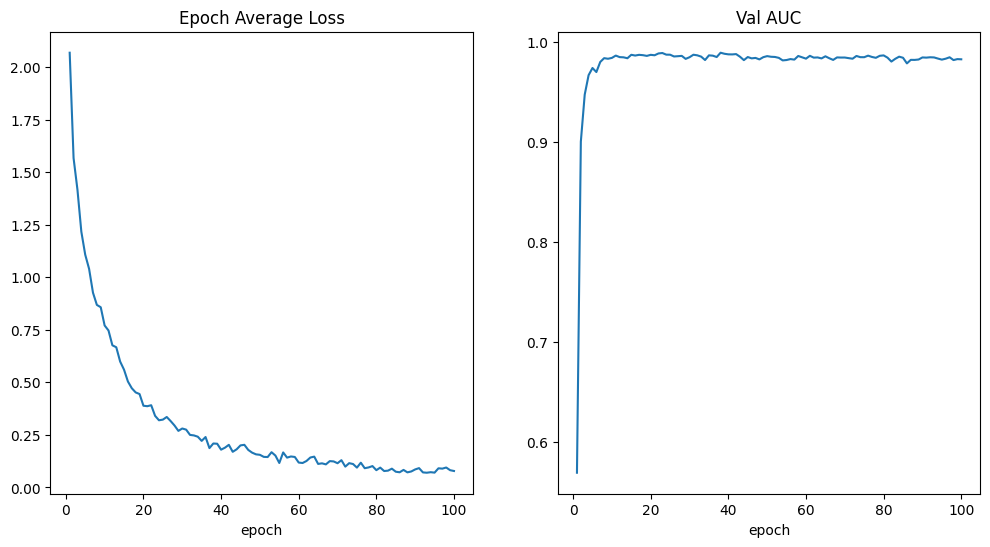

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [25]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [26]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8732    0.8986    0.8857        69
           1     0.5385    0.6176    0.5753        68
           2     0.7200    0.2609    0.3830        69
           3     0.4722    0.5231    0.4964        65
           4     0.5000    0.4000    0.4444        65
           5     0.7465    0.8030    0.7737        66
           6     0.8182    0.6429    0.7200        28
           7     1.0000    0.8571    0.9231        21
           8     0.8400    1.0000    0.9130        21
           9     0.6000    0.7391    0.6623        69
          10     0.5055    0.6667    0.5750        69

    accuracy                         0.6377       610
   macro avg     0.6922    0.6735    0.6684       610
weighted avg     0.6506    0.6377    0.6278       610



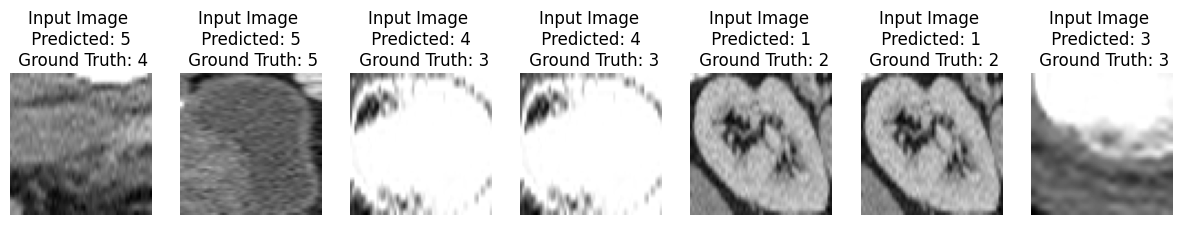

In [27]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.1410
1


Epochs:   1%|          | 1/100 [00:07<11:53,  7.21s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6368 current accuracy: 0.1491 best AUC: 0.6368 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.4252
1


Epochs:   2%|▏         | 2/100 [00:14<11:49,  7.24s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9714 current accuracy: 0.6584 best AUC: 0.9714 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.1081
1


Epochs:   3%|▎         | 3/100 [00:21<11:42,  7.24s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9842 current accuracy: 0.8075 best AUC: 0.9842 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.8948
1


Epochs:   4%|▍         | 4/100 [00:28<11:36,  7.25s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9905 current accuracy: 0.8820 best AUC: 0.9905 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.7949


Epochs:   5%|▌         | 5/100 [00:35<11:14,  7.10s/it]

1
current epoch: 5 current AUC: 0.9898 current accuracy: 0.8447 best AUC: 0.9905 at epoch: 4
----------
epoch 6/100
epoch 6 average loss: 0.7076


Epochs:   6%|▌         | 6/100 [00:42<10:59,  7.01s/it]

1
current epoch: 6 current AUC: 0.9870 current accuracy: 0.8137 best AUC: 0.9905 at epoch: 4
----------
epoch 7/100
epoch 7 average loss: 0.6556
1


Epochs:   7%|▋         | 7/100 [00:49<10:59,  7.09s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9914 current accuracy: 0.8509 best AUC: 0.9914 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.5907
1


Epochs:   8%|▊         | 8/100 [00:57<11:05,  7.24s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9914 current accuracy: 0.8323 best AUC: 0.9914 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.4907
1


Epochs:   9%|▉         | 9/100 [01:04<11:05,  7.31s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9924 current accuracy: 0.8509 best AUC: 0.9924 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.4450


Epochs:  10%|█         | 10/100 [01:12<10:52,  7.25s/it]

1
current epoch: 10 current AUC: 0.9908 current accuracy: 0.8509 best AUC: 0.9924 at epoch: 9
----------
epoch 11/100
epoch 11 average loss: 0.4519


Epochs:  11%|█         | 11/100 [01:19<10:40,  7.19s/it]

1
current epoch: 11 current AUC: 0.9889 current accuracy: 0.8385 best AUC: 0.9924 at epoch: 9
----------
epoch 12/100
epoch 12 average loss: 0.3985
1


Epochs:  12%|█▏        | 12/100 [01:26<10:40,  7.28s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9933 current accuracy: 0.8509 best AUC: 0.9933 at epoch: 12
----------
epoch 13/100
epoch 13 average loss: 0.3736


Epochs:  13%|█▎        | 13/100 [01:33<10:28,  7.22s/it]

1
current epoch: 13 current AUC: 0.9886 current accuracy: 0.8385 best AUC: 0.9933 at epoch: 12
----------
epoch 14/100
epoch 14 average loss: 0.3032


Epochs:  14%|█▍        | 14/100 [01:40<10:15,  7.16s/it]

1
current epoch: 14 current AUC: 0.9931 current accuracy: 0.8758 best AUC: 0.9933 at epoch: 12
----------
epoch 15/100
epoch 15 average loss: 0.2852


Epochs:  15%|█▌        | 15/100 [01:47<10:05,  7.12s/it]

1
current epoch: 15 current AUC: 0.9931 current accuracy: 0.8758 best AUC: 0.9933 at epoch: 12
----------
epoch 16/100
epoch 16 average loss: 0.3023


Epochs:  16%|█▌        | 16/100 [01:54<09:54,  7.08s/it]

1
current epoch: 16 current AUC: 0.9886 current accuracy: 0.8199 best AUC: 0.9933 at epoch: 12
----------
epoch 17/100
epoch 17 average loss: 0.2658


Epochs:  17%|█▋        | 17/100 [02:01<09:47,  7.08s/it]

1
current epoch: 17 current AUC: 0.9916 current accuracy: 0.8571 best AUC: 0.9933 at epoch: 12
----------
epoch 18/100
epoch 18 average loss: 0.2558


Epochs:  18%|█▊        | 18/100 [02:08<09:40,  7.08s/it]

1
current epoch: 18 current AUC: 0.9924 current accuracy: 0.8571 best AUC: 0.9933 at epoch: 12
----------
epoch 19/100
epoch 19 average loss: 0.2490


Epochs:  19%|█▉        | 19/100 [02:15<09:33,  7.08s/it]

1
current epoch: 19 current AUC: 0.9922 current accuracy: 0.8571 best AUC: 0.9933 at epoch: 12
----------
epoch 20/100
epoch 20 average loss: 0.2619
1


Epochs:  20%|██        | 20/100 [02:23<09:34,  7.19s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9974 current accuracy: 0.9255 best AUC: 0.9974 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.2111


Epochs:  21%|██        | 21/100 [02:30<09:24,  7.14s/it]

1
current epoch: 21 current AUC: 0.9870 current accuracy: 0.8447 best AUC: 0.9974 at epoch: 20
----------
epoch 22/100
epoch 22 average loss: 0.1822


Epochs:  22%|██▏       | 22/100 [02:37<09:14,  7.11s/it]

1
current epoch: 22 current AUC: 0.9900 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 23/100
epoch 23 average loss: 0.1920


Epochs:  23%|██▎       | 23/100 [02:44<09:05,  7.09s/it]

1
current epoch: 23 current AUC: 0.9920 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 24/100
epoch 24 average loss: 0.1743


Epochs:  24%|██▍       | 24/100 [02:51<08:57,  7.07s/it]

1
current epoch: 24 current AUC: 0.9911 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 25/100
epoch 25 average loss: 0.1550


Epochs:  25%|██▌       | 25/100 [02:58<08:50,  7.08s/it]

1
current epoch: 25 current AUC: 0.9899 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 26/100
epoch 26 average loss: 0.1609


Epochs:  26%|██▌       | 26/100 [03:05<08:42,  7.07s/it]

1
current epoch: 26 current AUC: 0.9897 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 27/100
epoch 27 average loss: 0.1543


Epochs:  27%|██▋       | 27/100 [03:12<08:36,  7.08s/it]

1
current epoch: 27 current AUC: 0.9898 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 28/100
epoch 28 average loss: 0.1462


Epochs:  28%|██▊       | 28/100 [03:19<08:28,  7.06s/it]

1
current epoch: 28 current AUC: 0.9918 current accuracy: 0.8447 best AUC: 0.9974 at epoch: 20
----------
epoch 29/100
epoch 29 average loss: 0.1359


Epochs:  29%|██▉       | 29/100 [03:26<08:22,  7.08s/it]

1
current epoch: 29 current AUC: 0.9837 current accuracy: 0.8323 best AUC: 0.9974 at epoch: 20
----------
epoch 30/100
epoch 30 average loss: 0.1611


Epochs:  30%|███       | 30/100 [03:33<08:13,  7.05s/it]

1
current epoch: 30 current AUC: 0.9889 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 31/100
epoch 31 average loss: 0.1032


Epochs:  31%|███       | 31/100 [03:40<08:06,  7.05s/it]

1
current epoch: 31 current AUC: 0.9922 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 32/100
epoch 32 average loss: 0.1292


Epochs:  32%|███▏      | 32/100 [03:47<07:58,  7.04s/it]

1
current epoch: 32 current AUC: 0.9913 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 33/100
epoch 33 average loss: 0.1052


Epochs:  33%|███▎      | 33/100 [03:55<07:52,  7.05s/it]

1
current epoch: 33 current AUC: 0.9902 current accuracy: 0.9006 best AUC: 0.9974 at epoch: 20
----------
epoch 34/100
epoch 34 average loss: 0.1241


Epochs:  34%|███▍      | 34/100 [04:02<07:46,  7.07s/it]

1
current epoch: 34 current AUC: 0.9916 current accuracy: 0.8758 best AUC: 0.9974 at epoch: 20
----------
epoch 35/100
epoch 35 average loss: 0.1316


Epochs:  35%|███▌      | 35/100 [04:09<07:37,  7.04s/it]

1
current epoch: 35 current AUC: 0.9893 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 36/100
epoch 36 average loss: 0.1303


Epochs:  36%|███▌      | 36/100 [04:16<07:30,  7.04s/it]

1
current epoch: 36 current AUC: 0.9926 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 37/100
epoch 37 average loss: 0.1024


Epochs:  37%|███▋      | 37/100 [04:23<07:23,  7.03s/it]

1
current epoch: 37 current AUC: 0.9910 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 38/100
epoch 38 average loss: 0.1131


Epochs:  38%|███▊      | 38/100 [04:30<07:16,  7.04s/it]

1
current epoch: 38 current AUC: 0.9923 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 39/100
epoch 39 average loss: 0.1006


Epochs:  39%|███▉      | 39/100 [04:37<07:10,  7.06s/it]

1
current epoch: 39 current AUC: 0.9935 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 40/100
epoch 40 average loss: 0.0823


Epochs:  40%|████      | 40/100 [04:44<07:04,  7.07s/it]

1
current epoch: 40 current AUC: 0.9911 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 41/100
epoch 41 average loss: 0.1035


Epochs:  41%|████      | 41/100 [04:51<06:55,  7.04s/it]

1
current epoch: 41 current AUC: 0.9853 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 42/100
epoch 42 average loss: 0.1053


Epochs:  42%|████▏     | 42/100 [04:58<06:48,  7.04s/it]

1
current epoch: 42 current AUC: 0.9840 current accuracy: 0.8261 best AUC: 0.9974 at epoch: 20
----------
epoch 43/100
epoch 43 average loss: 0.0999


Epochs:  43%|████▎     | 43/100 [05:05<06:43,  7.07s/it]

1
current epoch: 43 current AUC: 0.9911 current accuracy: 0.9006 best AUC: 0.9974 at epoch: 20
----------
epoch 44/100
epoch 44 average loss: 0.0798


Epochs:  44%|████▍     | 44/100 [05:12<06:35,  7.07s/it]

1
current epoch: 44 current AUC: 0.9887 current accuracy: 0.8758 best AUC: 0.9974 at epoch: 20
----------
epoch 45/100
epoch 45 average loss: 0.0778


Epochs:  45%|████▌     | 45/100 [05:19<06:28,  7.06s/it]

1
current epoch: 45 current AUC: 0.9922 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 46/100
epoch 46 average loss: 0.0967


Epochs:  46%|████▌     | 46/100 [05:26<06:22,  7.08s/it]

1
current epoch: 46 current AUC: 0.9860 current accuracy: 0.8385 best AUC: 0.9974 at epoch: 20
----------
epoch 47/100
epoch 47 average loss: 0.0800


Epochs:  47%|████▋     | 47/100 [05:33<06:15,  7.08s/it]

1
current epoch: 47 current AUC: 0.9932 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 48/100
epoch 48 average loss: 0.0737


Epochs:  48%|████▊     | 48/100 [05:41<06:08,  7.09s/it]

1
current epoch: 48 current AUC: 0.9887 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 49/100
epoch 49 average loss: 0.0579


Epochs:  49%|████▉     | 49/100 [05:48<06:00,  7.07s/it]

1
current epoch: 49 current AUC: 0.9892 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 50/100
epoch 50 average loss: 0.0702


Epochs:  50%|█████     | 50/100 [05:55<05:54,  7.09s/it]

1
current epoch: 50 current AUC: 0.9921 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 51/100
epoch 51 average loss: 0.0936


Epochs:  51%|█████     | 51/100 [06:02<05:46,  7.07s/it]

1
current epoch: 51 current AUC: 0.9891 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 52/100
epoch 52 average loss: 0.1003


Epochs:  52%|█████▏    | 52/100 [06:09<05:39,  7.08s/it]

1
current epoch: 52 current AUC: 0.9932 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 53/100
epoch 53 average loss: 0.0728


Epochs:  53%|█████▎    | 53/100 [06:16<05:32,  7.07s/it]

1
current epoch: 53 current AUC: 0.9887 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 54/100
epoch 54 average loss: 0.0676


Epochs:  54%|█████▍    | 54/100 [06:23<05:23,  7.03s/it]

1
current epoch: 54 current AUC: 0.9880 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 55/100
epoch 55 average loss: 0.0878


Epochs:  55%|█████▌    | 55/100 [06:30<05:16,  7.03s/it]

1
current epoch: 55 current AUC: 0.9935 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 56/100
epoch 56 average loss: 0.0689


Epochs:  56%|█████▌    | 56/100 [06:37<05:09,  7.04s/it]

1
current epoch: 56 current AUC: 0.9912 current accuracy: 0.8758 best AUC: 0.9974 at epoch: 20
----------
epoch 57/100
epoch 57 average loss: 0.0622


Epochs:  57%|█████▋    | 57/100 [06:44<05:02,  7.04s/it]

1
current epoch: 57 current AUC: 0.9924 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 58/100
epoch 58 average loss: 0.0718


Epochs:  58%|█████▊    | 58/100 [06:51<04:54,  7.00s/it]

1
current epoch: 58 current AUC: 0.9922 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 59/100
epoch 59 average loss: 0.0790


Epochs:  59%|█████▉    | 59/100 [06:58<04:47,  7.00s/it]

1
current epoch: 59 current AUC: 0.9847 current accuracy: 0.8447 best AUC: 0.9974 at epoch: 20
----------
epoch 60/100
epoch 60 average loss: 0.0679


Epochs:  60%|██████    | 60/100 [07:05<04:39,  6.99s/it]

1
current epoch: 60 current AUC: 0.9907 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 61/100
epoch 61 average loss: 0.0728


Epochs:  61%|██████    | 61/100 [07:12<04:32,  6.99s/it]

1
current epoch: 61 current AUC: 0.9913 current accuracy: 0.8758 best AUC: 0.9974 at epoch: 20
----------
epoch 62/100
epoch 62 average loss: 0.0774


Epochs:  62%|██████▏   | 62/100 [07:19<04:25,  6.98s/it]

1
current epoch: 62 current AUC: 0.9894 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 63/100
epoch 63 average loss: 0.0757


Epochs:  63%|██████▎   | 63/100 [07:26<04:19,  7.00s/it]

1
current epoch: 63 current AUC: 0.9830 current accuracy: 0.8571 best AUC: 0.9974 at epoch: 20
----------
epoch 64/100
epoch 64 average loss: 0.0559


Epochs:  64%|██████▍   | 64/100 [07:33<04:11,  7.00s/it]

1
current epoch: 64 current AUC: 0.9900 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 65/100
epoch 65 average loss: 0.0469


Epochs:  65%|██████▌   | 65/100 [07:40<04:04,  6.99s/it]

1
current epoch: 65 current AUC: 0.9891 current accuracy: 0.9068 best AUC: 0.9974 at epoch: 20
----------
epoch 66/100
epoch 66 average loss: 0.0604


Epochs:  66%|██████▌   | 66/100 [07:47<03:57,  7.00s/it]

1
current epoch: 66 current AUC: 0.9793 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 67/100
epoch 67 average loss: 0.0697


Epochs:  67%|██████▋   | 67/100 [07:54<03:51,  7.00s/it]

1
current epoch: 67 current AUC: 0.9862 current accuracy: 0.8944 best AUC: 0.9974 at epoch: 20
----------
epoch 68/100
epoch 68 average loss: 0.0576


Epochs:  68%|██████▊   | 68/100 [08:01<03:43,  6.99s/it]

1
current epoch: 68 current AUC: 0.9879 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 69/100
epoch 69 average loss: 0.0564


Epochs:  69%|██████▉   | 69/100 [08:08<03:37,  7.00s/it]

1
current epoch: 69 current AUC: 0.9842 current accuracy: 0.8385 best AUC: 0.9974 at epoch: 20
----------
epoch 70/100
epoch 70 average loss: 0.0695


Epochs:  70%|███████   | 70/100 [08:15<03:30,  7.01s/it]

1
current epoch: 70 current AUC: 0.9815 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 71/100
epoch 71 average loss: 0.0499


Epochs:  71%|███████   | 71/100 [08:22<03:23,  7.03s/it]

1
current epoch: 71 current AUC: 0.9828 current accuracy: 0.8571 best AUC: 0.9974 at epoch: 20
----------
epoch 72/100
epoch 72 average loss: 0.0588


Epochs:  72%|███████▏  | 72/100 [08:29<03:17,  7.04s/it]

1
current epoch: 72 current AUC: 0.9842 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 73/100
epoch 73 average loss: 0.0463


Epochs:  73%|███████▎  | 73/100 [08:36<03:09,  7.03s/it]

1
current epoch: 73 current AUC: 0.9851 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 74/100
epoch 74 average loss: 0.0431


Epochs:  74%|███████▍  | 74/100 [08:43<03:03,  7.04s/it]

1
current epoch: 74 current AUC: 0.9879 current accuracy: 0.9130 best AUC: 0.9974 at epoch: 20
----------
epoch 75/100
epoch 75 average loss: 0.0864


Epochs:  75%|███████▌  | 75/100 [08:50<02:55,  7.03s/it]

1
current epoch: 75 current AUC: 0.9879 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 76/100
epoch 76 average loss: 0.0782


Epochs:  76%|███████▌  | 76/100 [08:57<02:48,  7.03s/it]

1
current epoch: 76 current AUC: 0.9868 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 77/100
epoch 77 average loss: 0.0490


Epochs:  77%|███████▋  | 77/100 [09:04<02:41,  7.01s/it]

1
current epoch: 77 current AUC: 0.9862 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 78/100
epoch 78 average loss: 0.0589


Epochs:  78%|███████▊  | 78/100 [09:11<02:34,  7.03s/it]

1
current epoch: 78 current AUC: 0.9870 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 79/100
epoch 79 average loss: 0.0521


Epochs:  79%|███████▉  | 79/100 [09:18<02:27,  7.01s/it]

1
current epoch: 79 current AUC: 0.9874 current accuracy: 0.9068 best AUC: 0.9974 at epoch: 20
----------
epoch 80/100
epoch 80 average loss: 0.0491


Epochs:  80%|████████  | 80/100 [09:25<02:19,  6.99s/it]

1
current epoch: 80 current AUC: 0.9857 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 81/100
epoch 81 average loss: 0.0501


Epochs:  81%|████████  | 81/100 [09:32<02:12,  6.98s/it]

1
current epoch: 81 current AUC: 0.9925 current accuracy: 0.8944 best AUC: 0.9974 at epoch: 20
----------
epoch 82/100
epoch 82 average loss: 0.0516


Epochs:  82%|████████▏ | 82/100 [09:39<02:05,  6.99s/it]

1
current epoch: 82 current AUC: 0.9865 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 20
----------
epoch 83/100
epoch 83 average loss: 0.0525


Epochs:  83%|████████▎ | 83/100 [09:46<01:58,  6.99s/it]

1
current epoch: 83 current AUC: 0.9849 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 84/100
epoch 84 average loss: 0.0596


Epochs:  84%|████████▍ | 84/100 [09:53<01:51,  6.97s/it]

1
current epoch: 84 current AUC: 0.9867 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 85/100
epoch 85 average loss: 0.0518


Epochs:  85%|████████▌ | 85/100 [10:00<01:44,  6.98s/it]

1
current epoch: 85 current AUC: 0.9857 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 86/100
epoch 86 average loss: 0.0736


Epochs:  86%|████████▌ | 86/100 [10:07<01:37,  6.98s/it]

1
current epoch: 86 current AUC: 0.9866 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 87/100
epoch 87 average loss: 0.0535


Epochs:  87%|████████▋ | 87/100 [10:14<01:30,  6.97s/it]

1
current epoch: 87 current AUC: 0.9892 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 88/100
epoch 88 average loss: 0.0421


Epochs:  88%|████████▊ | 88/100 [10:21<01:23,  6.99s/it]

1
current epoch: 88 current AUC: 0.9816 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 89/100
epoch 89 average loss: 0.0379


Epochs:  89%|████████▉ | 89/100 [10:28<01:16,  6.97s/it]

1
current epoch: 89 current AUC: 0.9880 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 90/100
epoch 90 average loss: 0.0519


Epochs:  90%|█████████ | 90/100 [10:35<01:09,  6.95s/it]

1
current epoch: 90 current AUC: 0.9812 current accuracy: 0.8323 best AUC: 0.9974 at epoch: 20
----------
epoch 91/100
epoch 91 average loss: 0.0310


Epochs:  91%|█████████ | 91/100 [10:42<01:02,  6.96s/it]

1
current epoch: 91 current AUC: 0.9855 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 92/100
epoch 92 average loss: 0.0534


Epochs:  92%|█████████▏| 92/100 [10:49<00:55,  6.98s/it]

1
current epoch: 92 current AUC: 0.9879 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 93/100
epoch 93 average loss: 0.0524


Epochs:  93%|█████████▎| 93/100 [10:56<00:48,  6.97s/it]

1
current epoch: 93 current AUC: 0.9916 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
----------
epoch 94/100
epoch 94 average loss: 0.0459


Epochs:  94%|█████████▍| 94/100 [11:03<00:41,  6.95s/it]

1
current epoch: 94 current AUC: 0.9871 current accuracy: 0.8509 best AUC: 0.9974 at epoch: 20
----------
epoch 95/100
epoch 95 average loss: 0.0367


Epochs:  95%|█████████▌| 95/100 [11:10<00:34,  6.95s/it]

1
current epoch: 95 current AUC: 0.9931 current accuracy: 0.8758 best AUC: 0.9974 at epoch: 20
----------
epoch 96/100
epoch 96 average loss: 0.0304


Epochs:  96%|█████████▌| 96/100 [11:17<00:27,  6.98s/it]

1
current epoch: 96 current AUC: 0.9855 current accuracy: 0.8634 best AUC: 0.9974 at epoch: 20
----------
epoch 97/100
epoch 97 average loss: 0.0373


Epochs:  97%|█████████▋| 97/100 [11:23<00:20,  6.97s/it]

1
current epoch: 97 current AUC: 0.9846 current accuracy: 0.8447 best AUC: 0.9974 at epoch: 20
----------
epoch 98/100
epoch 98 average loss: 0.0377


Epochs:  98%|█████████▊| 98/100 [11:30<00:13,  6.96s/it]

1
current epoch: 98 current AUC: 0.9876 current accuracy: 0.8696 best AUC: 0.9974 at epoch: 20
----------
epoch 99/100
epoch 99 average loss: 0.0356


Epochs:  99%|█████████▉| 99/100 [11:37<00:06,  6.94s/it]

1
current epoch: 99 current AUC: 0.9866 current accuracy: 0.8385 best AUC: 0.9974 at epoch: 20
----------
epoch 100/100
epoch 100 average loss: 0.0219


Epochs: 100%|██████████| 100/100 [11:44<00:00,  7.05s/it]

1
current epoch: 100 current AUC: 0.9885 current accuracy: 0.8882 best AUC: 0.9974 at epoch: 20
train completed, best_metric: 0.9974 at epoch: 20


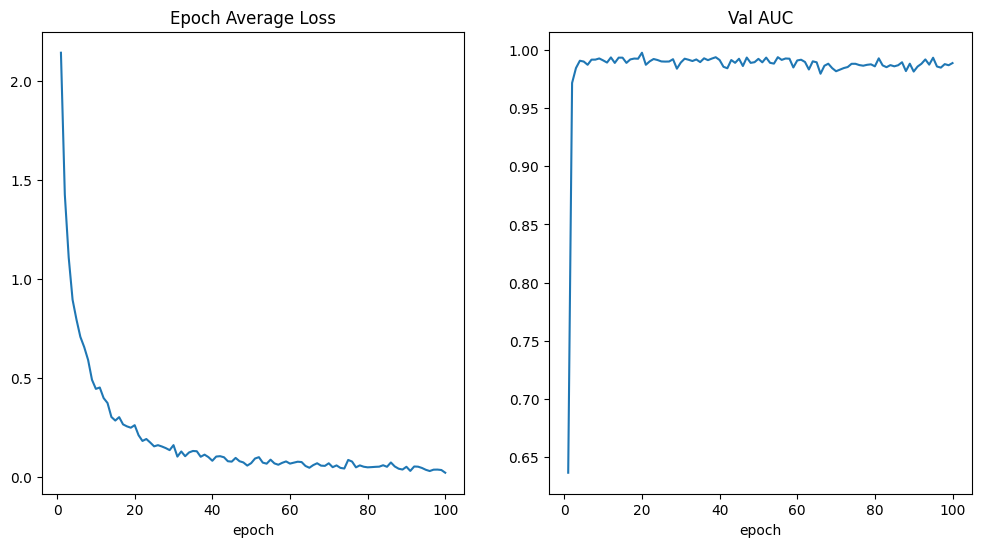

In [30]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [31]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [32]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9000    0.9130    0.9065        69
           1     0.5890    0.6324    0.6099        68
           2     0.6538    0.4928    0.5620        69
           3     0.6471    0.6769    0.6617        65
           4     0.6034    0.5385    0.5691        65
           5     0.7746    0.8333    0.8029        66
           6     0.8800    0.7857    0.8302        28
           7     1.0000    0.9048    0.9500        21
           8     0.8696    0.9524    0.9091        21
           9     0.7237    0.7971    0.7586        69
          10     0.8267    0.8986    0.8611        69

    accuracy                         0.7410       610
   macro avg     0.7698    0.7659    0.7656       610
weighted avg     0.7386    0.7410    0.7374       610



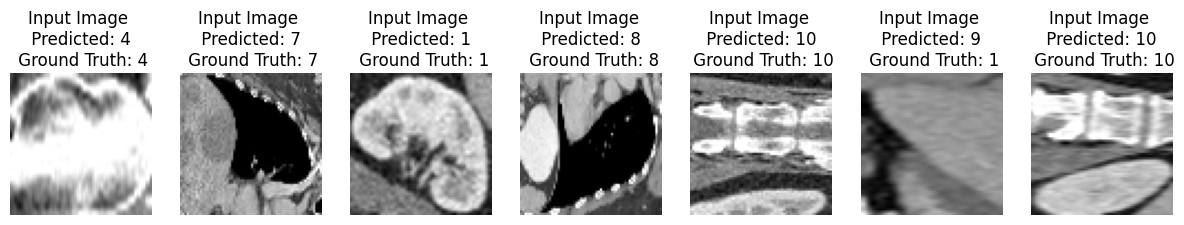

In [33]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_coronal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [35]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0852
1


Epochs:   1%|          | 1/100 [00:07<11:49,  7.17s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6077 current accuracy: 0.0932 best AUC: 0.6077 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5595
1


Epochs:   2%|▏         | 2/100 [00:14<11:39,  7.13s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9432 current accuracy: 0.5217 best AUC: 0.9432 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.2472
1


Epochs:   3%|▎         | 3/100 [00:21<11:33,  7.15s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9732 current accuracy: 0.6708 best AUC: 0.9732 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.0559
1


Epochs:   4%|▍         | 4/100 [00:28<11:25,  7.14s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9763 current accuracy: 0.7205 best AUC: 0.9763 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.9271
1


Epochs:   5%|▌         | 5/100 [00:35<11:18,  7.14s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9816 current accuracy: 0.7019 best AUC: 0.9816 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.8123
1


Epochs:   6%|▌         | 6/100 [00:42<10:57,  6.99s/it]

current epoch: 6 current AUC: 0.9781 current accuracy: 0.7640 best AUC: 0.9816 at epoch: 5
----------
epoch 7/100
epoch 7 average loss: 0.7651
1


Epochs:   7%|▋         | 7/100 [00:49<10:54,  7.04s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9820 current accuracy: 0.8199 best AUC: 0.9820 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.7154
1


Epochs:   8%|▊         | 8/100 [00:56<10:49,  7.06s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9847 current accuracy: 0.7950 best AUC: 0.9847 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.6664
1


Epochs:   9%|▉         | 9/100 [01:03<10:33,  6.96s/it]

current epoch: 9 current AUC: 0.9828 current accuracy: 0.7888 best AUC: 0.9847 at epoch: 8
----------
epoch 10/100
epoch 10 average loss: 0.6186
1


Epochs:  10%|█         | 10/100 [01:10<10:31,  7.02s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9850 current accuracy: 0.8012 best AUC: 0.9850 at epoch: 10
----------
epoch 11/100
epoch 11 average loss: 0.5626
1


Epochs:  11%|█         | 11/100 [01:17<10:29,  7.08s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9855 current accuracy: 0.7826 best AUC: 0.9855 at epoch: 11
----------
epoch 12/100
epoch 12 average loss: 0.5359
1


Epochs:  12%|█▏        | 12/100 [01:24<10:12,  6.96s/it]

current epoch: 12 current AUC: 0.9816 current accuracy: 0.7640 best AUC: 0.9855 at epoch: 11
----------
epoch 13/100
epoch 13 average loss: 0.5416
1


Epochs:  13%|█▎        | 13/100 [01:31<10:10,  7.02s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9878 current accuracy: 0.8075 best AUC: 0.9878 at epoch: 13
----------
epoch 14/100
epoch 14 average loss: 0.5263
1


Epochs:  14%|█▍        | 14/100 [01:38<09:55,  6.92s/it]

current epoch: 14 current AUC: 0.9806 current accuracy: 0.7578 best AUC: 0.9878 at epoch: 13
----------
epoch 15/100
epoch 15 average loss: 0.4660
1


Epochs:  15%|█▌        | 15/100 [01:45<09:55,  7.00s/it]

saved new best metric model
current epoch: 15 current AUC: 0.9881 current accuracy: 0.8012 best AUC: 0.9881 at epoch: 15
----------
epoch 16/100
epoch 16 average loss: 0.4421
1


Epochs:  16%|█▌        | 16/100 [01:52<09:41,  6.93s/it]

current epoch: 16 current AUC: 0.9848 current accuracy: 0.7888 best AUC: 0.9881 at epoch: 15
----------
epoch 17/100
epoch 17 average loss: 0.4352
1


Epochs:  17%|█▋        | 17/100 [01:58<09:30,  6.87s/it]

current epoch: 17 current AUC: 0.9858 current accuracy: 0.8075 best AUC: 0.9881 at epoch: 15
----------
epoch 18/100
epoch 18 average loss: 0.3836
1


Epochs:  18%|█▊        | 18/100 [02:06<09:29,  6.94s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9899 current accuracy: 0.8447 best AUC: 0.9899 at epoch: 18
----------
epoch 19/100
epoch 19 average loss: 0.3516
1


Epochs:  19%|█▉        | 19/100 [02:12<09:19,  6.90s/it]

current epoch: 19 current AUC: 0.9886 current accuracy: 0.8075 best AUC: 0.9899 at epoch: 18
----------
epoch 20/100
epoch 20 average loss: 0.3364
1


Epochs:  20%|██        | 20/100 [02:20<09:17,  6.97s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9907 current accuracy: 0.8447 best AUC: 0.9907 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.3179
1


Epochs:  21%|██        | 21/100 [02:26<09:06,  6.91s/it]

current epoch: 21 current AUC: 0.9901 current accuracy: 0.8199 best AUC: 0.9907 at epoch: 20
----------
epoch 22/100
epoch 22 average loss: 0.3024
1


Epochs:  22%|██▏       | 22/100 [02:33<08:55,  6.86s/it]

current epoch: 22 current AUC: 0.9862 current accuracy: 0.8137 best AUC: 0.9907 at epoch: 20
----------
epoch 23/100
epoch 23 average loss: 0.2851
1


Epochs:  23%|██▎       | 23/100 [02:40<08:46,  6.84s/it]

current epoch: 23 current AUC: 0.9897 current accuracy: 0.8447 best AUC: 0.9907 at epoch: 20
----------
epoch 24/100
epoch 24 average loss: 0.2832
1


Epochs:  24%|██▍       | 24/100 [02:47<08:38,  6.82s/it]

current epoch: 24 current AUC: 0.9893 current accuracy: 0.8137 best AUC: 0.9907 at epoch: 20
----------
epoch 25/100
epoch 25 average loss: 0.2948
1


Epochs:  25%|██▌       | 25/100 [02:53<08:29,  6.79s/it]

current epoch: 25 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9907 at epoch: 20
----------
epoch 26/100
epoch 26 average loss: 0.2610
1


Epochs:  26%|██▌       | 26/100 [03:00<08:20,  6.77s/it]

current epoch: 26 current AUC: 0.9884 current accuracy: 0.7950 best AUC: 0.9907 at epoch: 20
----------
epoch 27/100
epoch 27 average loss: 0.2527
1


Epochs:  27%|██▋       | 27/100 [03:07<08:13,  6.76s/it]

current epoch: 27 current AUC: 0.9890 current accuracy: 0.8634 best AUC: 0.9907 at epoch: 20
----------
epoch 28/100
epoch 28 average loss: 0.2287
1


Epochs:  28%|██▊       | 28/100 [03:14<08:06,  6.75s/it]

current epoch: 28 current AUC: 0.9877 current accuracy: 0.8261 best AUC: 0.9907 at epoch: 20
----------
epoch 29/100
epoch 29 average loss: 0.2344
1


Epochs:  29%|██▉       | 29/100 [03:20<07:59,  6.75s/it]

current epoch: 29 current AUC: 0.9888 current accuracy: 0.8199 best AUC: 0.9907 at epoch: 20
----------
epoch 30/100
epoch 30 average loss: 0.2057
1


Epochs:  30%|███       | 30/100 [03:27<07:52,  6.75s/it]

current epoch: 30 current AUC: 0.9863 current accuracy: 0.8137 best AUC: 0.9907 at epoch: 20
----------
epoch 31/100
epoch 31 average loss: 0.2116
1


Epochs:  31%|███       | 31/100 [03:34<07:47,  6.77s/it]

current epoch: 31 current AUC: 0.9856 current accuracy: 0.8261 best AUC: 0.9907 at epoch: 20
----------
epoch 32/100
epoch 32 average loss: 0.1976
1


Epochs:  32%|███▏      | 32/100 [03:41<07:39,  6.76s/it]

current epoch: 32 current AUC: 0.9896 current accuracy: 0.8199 best AUC: 0.9907 at epoch: 20
----------
epoch 33/100
epoch 33 average loss: 0.1924
1


Epochs:  33%|███▎      | 33/100 [03:47<07:31,  6.74s/it]

current epoch: 33 current AUC: 0.9820 current accuracy: 0.8261 best AUC: 0.9907 at epoch: 20
----------
epoch 34/100
epoch 34 average loss: 0.2209
1


Epochs:  34%|███▍      | 34/100 [03:54<07:24,  6.74s/it]

current epoch: 34 current AUC: 0.9903 current accuracy: 0.8634 best AUC: 0.9907 at epoch: 20
----------
epoch 35/100
epoch 35 average loss: 0.1751
1


Epochs:  35%|███▌      | 35/100 [04:01<07:16,  6.72s/it]

current epoch: 35 current AUC: 0.9824 current accuracy: 0.7764 best AUC: 0.9907 at epoch: 20
----------
epoch 36/100
epoch 36 average loss: 0.1803
1


Epochs:  36%|███▌      | 36/100 [04:07<07:09,  6.71s/it]

current epoch: 36 current AUC: 0.9901 current accuracy: 0.8571 best AUC: 0.9907 at epoch: 20
----------
epoch 37/100
epoch 37 average loss: 0.2015
1


Epochs:  37%|███▋      | 37/100 [04:14<07:05,  6.75s/it]

current epoch: 37 current AUC: 0.9879 current accuracy: 0.8385 best AUC: 0.9907 at epoch: 20
----------
epoch 38/100
epoch 38 average loss: 0.1584
1


Epochs:  38%|███▊      | 38/100 [04:21<06:58,  6.75s/it]

current epoch: 38 current AUC: 0.9885 current accuracy: 0.8012 best AUC: 0.9907 at epoch: 20
----------
epoch 39/100
epoch 39 average loss: 0.1359
1


Epochs:  39%|███▉      | 39/100 [04:28<06:52,  6.76s/it]

current epoch: 39 current AUC: 0.9903 current accuracy: 0.8509 best AUC: 0.9907 at epoch: 20
----------
epoch 40/100
epoch 40 average loss: 0.1560
1


Epochs:  40%|████      | 40/100 [04:35<06:54,  6.90s/it]

saved new best metric model
current epoch: 40 current AUC: 0.9935 current accuracy: 0.8447 best AUC: 0.9935 at epoch: 40
----------
epoch 41/100
epoch 41 average loss: 0.1454
1


Epochs:  41%|████      | 41/100 [04:42<06:43,  6.84s/it]

current epoch: 41 current AUC: 0.9911 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 40
----------
epoch 42/100
epoch 42 average loss: 0.1406
1


Epochs:  42%|████▏     | 42/100 [04:48<06:34,  6.80s/it]

current epoch: 42 current AUC: 0.9898 current accuracy: 0.8758 best AUC: 0.9935 at epoch: 40
----------
epoch 43/100
epoch 43 average loss: 0.1621
1


Epochs:  43%|████▎     | 43/100 [04:55<06:26,  6.79s/it]

current epoch: 43 current AUC: 0.9892 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 44/100
epoch 44 average loss: 0.1497
1


Epochs:  44%|████▍     | 44/100 [05:02<06:19,  6.78s/it]

current epoch: 44 current AUC: 0.9932 current accuracy: 0.8944 best AUC: 0.9935 at epoch: 40
----------
epoch 45/100
epoch 45 average loss: 0.1385
1


Epochs:  45%|████▌     | 45/100 [05:09<06:11,  6.76s/it]

current epoch: 45 current AUC: 0.9919 current accuracy: 0.8944 best AUC: 0.9935 at epoch: 40
----------
epoch 46/100
epoch 46 average loss: 0.1278
1


Epochs:  46%|████▌     | 46/100 [05:15<06:04,  6.75s/it]

current epoch: 46 current AUC: 0.9906 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 47/100
epoch 47 average loss: 0.1303
1


Epochs:  47%|████▋     | 47/100 [05:22<05:57,  6.75s/it]

current epoch: 47 current AUC: 0.9886 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 40
----------
epoch 48/100
epoch 48 average loss: 0.1050
1


Epochs:  48%|████▊     | 48/100 [05:29<05:52,  6.78s/it]

current epoch: 48 current AUC: 0.9912 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 40
----------
epoch 49/100
epoch 49 average loss: 0.1158
1


Epochs:  49%|████▉     | 49/100 [05:36<05:46,  6.79s/it]

current epoch: 49 current AUC: 0.9881 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
----------
epoch 50/100
epoch 50 average loss: 0.1182
1


Epochs:  50%|█████     | 50/100 [05:43<05:39,  6.80s/it]

current epoch: 50 current AUC: 0.9917 current accuracy: 0.8634 best AUC: 0.9935 at epoch: 40
----------
epoch 51/100
epoch 51 average loss: 0.1166
1


Epochs:  51%|█████     | 51/100 [05:49<05:32,  6.78s/it]

current epoch: 51 current AUC: 0.9893 current accuracy: 0.8261 best AUC: 0.9935 at epoch: 40
----------
epoch 52/100
epoch 52 average loss: 0.1093
1


Epochs:  52%|█████▏    | 52/100 [05:56<05:24,  6.76s/it]

current epoch: 52 current AUC: 0.9906 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 53/100
epoch 53 average loss: 0.1195
1


Epochs:  53%|█████▎    | 53/100 [06:03<05:16,  6.74s/it]

current epoch: 53 current AUC: 0.9840 current accuracy: 0.8261 best AUC: 0.9935 at epoch: 40
----------
epoch 54/100
epoch 54 average loss: 0.0928
1


Epochs:  54%|█████▍    | 54/100 [06:09<05:10,  6.74s/it]

current epoch: 54 current AUC: 0.9872 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 55/100
epoch 55 average loss: 0.1296
1


Epochs:  55%|█████▌    | 55/100 [06:16<05:04,  6.77s/it]

current epoch: 55 current AUC: 0.9856 current accuracy: 0.8075 best AUC: 0.9935 at epoch: 40
----------
epoch 56/100
epoch 56 average loss: 0.1239
1


Epochs:  56%|█████▌    | 56/100 [06:23<04:58,  6.77s/it]

current epoch: 56 current AUC: 0.9861 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
----------
epoch 57/100
epoch 57 average loss: 0.1198
1


Epochs:  57%|█████▋    | 57/100 [06:30<04:51,  6.77s/it]

current epoch: 57 current AUC: 0.9897 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 58/100
epoch 58 average loss: 0.0945
1


Epochs:  58%|█████▊    | 58/100 [06:37<04:43,  6.76s/it]

current epoch: 58 current AUC: 0.9863 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
----------
epoch 59/100
epoch 59 average loss: 0.0995
1


Epochs:  59%|█████▉    | 59/100 [06:43<04:37,  6.77s/it]

current epoch: 59 current AUC: 0.9898 current accuracy: 0.8075 best AUC: 0.9935 at epoch: 40
----------
epoch 60/100
epoch 60 average loss: 0.0828
1


Epochs:  60%|██████    | 60/100 [06:50<04:30,  6.77s/it]

current epoch: 60 current AUC: 0.9929 current accuracy: 0.8758 best AUC: 0.9935 at epoch: 40
----------
epoch 61/100
epoch 61 average loss: 0.0835
1


Epochs:  61%|██████    | 61/100 [06:57<04:24,  6.78s/it]

current epoch: 61 current AUC: 0.9879 current accuracy: 0.8012 best AUC: 0.9935 at epoch: 40
----------
epoch 62/100
epoch 62 average loss: 0.1226
1


Epochs:  62%|██████▏   | 62/100 [07:04<04:16,  6.76s/it]

current epoch: 62 current AUC: 0.9901 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 40
----------
epoch 63/100
epoch 63 average loss: 0.1256
1


Epochs:  63%|██████▎   | 63/100 [07:10<04:10,  6.77s/it]

current epoch: 63 current AUC: 0.9883 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
----------
epoch 64/100
epoch 64 average loss: 0.0860
1


Epochs:  64%|██████▍   | 64/100 [07:17<04:02,  6.74s/it]

current epoch: 64 current AUC: 0.9905 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 40
----------
epoch 65/100
epoch 65 average loss: 0.1071
1


Epochs:  65%|██████▌   | 65/100 [07:24<03:55,  6.74s/it]

current epoch: 65 current AUC: 0.9889 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 66/100
epoch 66 average loss: 0.0784
1


Epochs:  66%|██████▌   | 66/100 [07:31<03:48,  6.73s/it]

current epoch: 66 current AUC: 0.9913 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 67/100
epoch 67 average loss: 0.0728
1


Epochs:  67%|██████▋   | 67/100 [07:37<03:41,  6.72s/it]

current epoch: 67 current AUC: 0.9883 current accuracy: 0.8447 best AUC: 0.9935 at epoch: 40
----------
epoch 68/100
epoch 68 average loss: 0.0938
1


Epochs:  68%|██████▊   | 68/100 [07:44<03:35,  6.74s/it]

current epoch: 68 current AUC: 0.9916 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 69/100
epoch 69 average loss: 0.0672
1


Epochs:  69%|██████▉   | 69/100 [07:51<03:29,  6.74s/it]

current epoch: 69 current AUC: 0.9898 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 70/100
epoch 70 average loss: 0.1252
1


Epochs:  70%|███████   | 70/100 [07:58<03:22,  6.75s/it]

current epoch: 70 current AUC: 0.9856 current accuracy: 0.7888 best AUC: 0.9935 at epoch: 40
----------
epoch 71/100
epoch 71 average loss: 0.0917
1


Epochs:  71%|███████   | 71/100 [08:04<03:15,  6.75s/it]

current epoch: 71 current AUC: 0.9887 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 40
----------
epoch 72/100
epoch 72 average loss: 0.1036
1


Epochs:  72%|███████▏  | 72/100 [08:11<03:09,  6.75s/it]

current epoch: 72 current AUC: 0.9878 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 73/100
epoch 73 average loss: 0.1134
1


Epochs:  73%|███████▎  | 73/100 [08:18<03:02,  6.76s/it]

current epoch: 73 current AUC: 0.9887 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
----------
epoch 74/100
epoch 74 average loss: 0.0913
1


Epochs:  74%|███████▍  | 74/100 [08:25<02:55,  6.76s/it]

current epoch: 74 current AUC: 0.9877 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 75/100
epoch 75 average loss: 0.1091
1


Epochs:  75%|███████▌  | 75/100 [08:31<02:49,  6.76s/it]

current epoch: 75 current AUC: 0.9862 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 76/100
epoch 76 average loss: 0.1151
1


Epochs:  76%|███████▌  | 76/100 [08:38<02:42,  6.78s/it]

current epoch: 76 current AUC: 0.9899 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 40
----------
epoch 77/100
epoch 77 average loss: 0.0838
1


Epochs:  77%|███████▋  | 77/100 [08:45<02:35,  6.77s/it]

current epoch: 77 current AUC: 0.9876 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 78/100
epoch 78 average loss: 0.0662
1


Epochs:  78%|███████▊  | 78/100 [08:52<02:28,  6.77s/it]

current epoch: 78 current AUC: 0.9879 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 79/100
epoch 79 average loss: 0.0829
1


Epochs:  79%|███████▉  | 79/100 [08:58<02:21,  6.76s/it]

current epoch: 79 current AUC: 0.9868 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 40
----------
epoch 80/100
epoch 80 average loss: 0.0608
1


Epochs:  80%|████████  | 80/100 [09:05<02:14,  6.73s/it]

current epoch: 80 current AUC: 0.9896 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 40
----------
epoch 81/100
epoch 81 average loss: 0.0716
1


Epochs:  81%|████████  | 81/100 [09:12<02:08,  6.78s/it]

current epoch: 81 current AUC: 0.9860 current accuracy: 0.8261 best AUC: 0.9935 at epoch: 40
----------
epoch 82/100
epoch 82 average loss: 0.0670
1


Epochs:  82%|████████▏ | 82/100 [09:19<02:02,  6.78s/it]

current epoch: 82 current AUC: 0.9893 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 83/100
epoch 83 average loss: 0.0674
1


Epochs:  83%|████████▎ | 83/100 [09:26<01:55,  6.78s/it]

current epoch: 83 current AUC: 0.9904 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 84/100
epoch 84 average loss: 0.0941
1


Epochs:  84%|████████▍ | 84/100 [09:32<01:48,  6.78s/it]

current epoch: 84 current AUC: 0.9893 current accuracy: 0.8634 best AUC: 0.9935 at epoch: 40
----------
epoch 85/100
epoch 85 average loss: 0.0968
1


Epochs:  85%|████████▌ | 85/100 [09:39<01:41,  6.78s/it]

current epoch: 85 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 86/100
epoch 86 average loss: 0.0781
1


Epochs:  86%|████████▌ | 86/100 [09:46<01:34,  6.77s/it]

current epoch: 86 current AUC: 0.9922 current accuracy: 0.8758 best AUC: 0.9935 at epoch: 40
----------
epoch 87/100
epoch 87 average loss: 0.0646
1


Epochs:  87%|████████▋ | 87/100 [09:53<01:27,  6.76s/it]

current epoch: 87 current AUC: 0.9900 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 88/100
epoch 88 average loss: 0.0655
1


Epochs:  88%|████████▊ | 88/100 [09:59<01:21,  6.76s/it]

current epoch: 88 current AUC: 0.9862 current accuracy: 0.8261 best AUC: 0.9935 at epoch: 40
----------
epoch 89/100
epoch 89 average loss: 0.0711
1


Epochs:  89%|████████▉ | 89/100 [10:06<01:14,  6.75s/it]

current epoch: 89 current AUC: 0.9900 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 90/100
epoch 90 average loss: 0.0560
1


Epochs:  90%|█████████ | 90/100 [10:13<01:07,  6.75s/it]

current epoch: 90 current AUC: 0.9882 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 40
----------
epoch 91/100
epoch 91 average loss: 0.0700
1


Epochs:  91%|█████████ | 91/100 [10:20<01:00,  6.76s/it]

current epoch: 91 current AUC: 0.9915 current accuracy: 0.8882 best AUC: 0.9935 at epoch: 40
----------
epoch 92/100
epoch 92 average loss: 0.0627
1


Epochs:  92%|█████████▏| 92/100 [10:26<00:54,  6.76s/it]

current epoch: 92 current AUC: 0.9883 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 40
----------
epoch 93/100
epoch 93 average loss: 0.0686
1


Epochs:  93%|█████████▎| 93/100 [10:33<00:47,  6.75s/it]

current epoch: 93 current AUC: 0.9874 current accuracy: 0.8696 best AUC: 0.9935 at epoch: 40
----------
epoch 94/100
epoch 94 average loss: 0.0778
1


Epochs:  94%|█████████▍| 94/100 [10:40<00:40,  6.74s/it]

current epoch: 94 current AUC: 0.9868 current accuracy: 0.8634 best AUC: 0.9935 at epoch: 40
----------
epoch 95/100
epoch 95 average loss: 0.0697
1


Epochs:  95%|█████████▌| 95/100 [10:47<00:33,  6.74s/it]

current epoch: 95 current AUC: 0.9837 current accuracy: 0.8447 best AUC: 0.9935 at epoch: 40
----------
epoch 96/100
epoch 96 average loss: 0.0659
1


Epochs:  96%|█████████▌| 96/100 [10:53<00:26,  6.73s/it]

current epoch: 96 current AUC: 0.9916 current accuracy: 0.8634 best AUC: 0.9935 at epoch: 40
----------
epoch 97/100
epoch 97 average loss: 0.0478
1


Epochs:  97%|█████████▋| 97/100 [11:00<00:20,  6.72s/it]

current epoch: 97 current AUC: 0.9887 current accuracy: 0.8820 best AUC: 0.9935 at epoch: 40
----------
epoch 98/100
epoch 98 average loss: 0.0445
1


Epochs:  98%|█████████▊| 98/100 [11:07<00:13,  6.72s/it]

current epoch: 98 current AUC: 0.9900 current accuracy: 0.8882 best AUC: 0.9935 at epoch: 40
----------
epoch 99/100
epoch 99 average loss: 0.0647
1


Epochs:  99%|█████████▉| 99/100 [11:13<00:06,  6.71s/it]

current epoch: 99 current AUC: 0.9841 current accuracy: 0.8261 best AUC: 0.9935 at epoch: 40
----------
epoch 100/100
epoch 100 average loss: 0.0768
1


Epochs: 100%|██████████| 100/100 [11:20<00:00,  6.81s/it]

current epoch: 100 current AUC: 0.9867 current accuracy: 0.8137 best AUC: 0.9935 at epoch: 40
train completed, best_metric: 0.9935 at epoch: 40


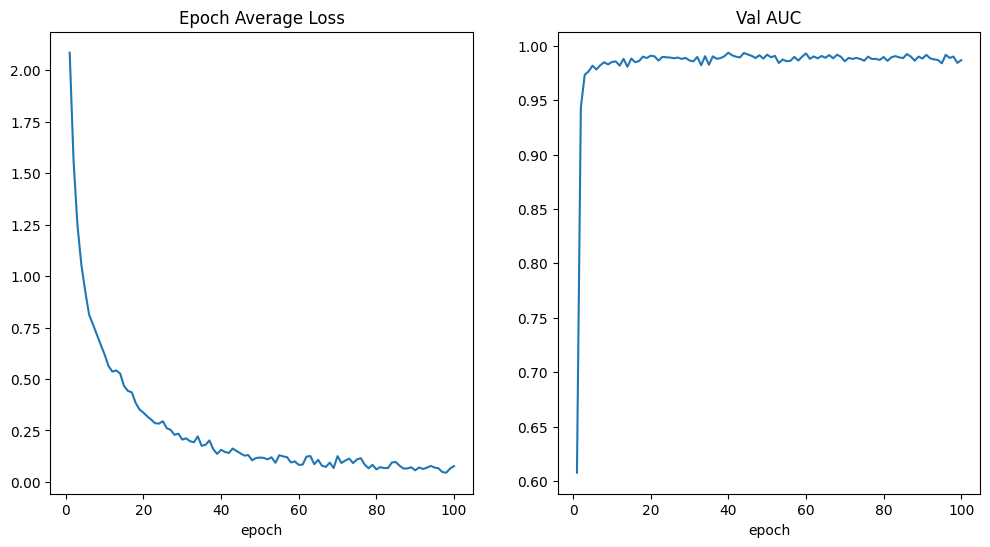

In [36]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [37]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [38]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8806    0.8551    0.8676        69
           1     0.4556    0.6029    0.5190        68
           2     0.5789    0.3188    0.4112        69
           3     0.5104    0.7538    0.6087        65
           4     0.5102    0.3846    0.4386        65
           5     0.7812    0.7576    0.7692        66
           6     0.7333    0.3929    0.5116        28
           7     0.7500    1.0000    0.8571        21
           8     0.9286    0.6190    0.7429        21
           9     0.5679    0.6667    0.6133        69
          10     0.4853    0.4783    0.4818        69

    accuracy                         0.6066       610
   macro avg     0.6529    0.6209    0.6201       610
weighted avg     0.6197    0.6066    0.5998       610



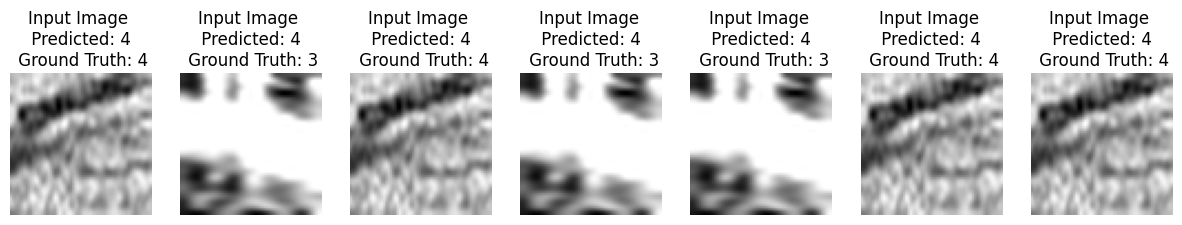

In [39]:
plot_examples(test_coronal, pred, test_labels, n=7)

## Training cycle for the sagittal part

## Pretrained

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.1879
1


Epochs:   1%|          | 1/100 [00:07<12:07,  7.35s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5814 current accuracy: 0.1553 best AUC: 0.5814 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.4584
1


Epochs:   2%|▏         | 2/100 [00:14<11:51,  7.26s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9626 current accuracy: 0.6087 best AUC: 0.9626 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.1102


Epochs:   3%|▎         | 3/100 [00:21<11:24,  7.06s/it]

1
current epoch: 3 current AUC: 0.9590 current accuracy: 0.6646 best AUC: 0.9626 at epoch: 2
----------
epoch 4/100
epoch 4 average loss: 0.9566
1


Epochs:   4%|▍         | 4/100 [00:28<11:27,  7.16s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9843 current accuracy: 0.8323 best AUC: 0.9843 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.8318


Epochs:   5%|▌         | 5/100 [00:35<11:11,  7.07s/it]

1
current epoch: 5 current AUC: 0.9803 current accuracy: 0.8012 best AUC: 0.9843 at epoch: 4
----------
epoch 6/100
epoch 6 average loss: 0.7506


Epochs:   6%|▌         | 6/100 [00:42<10:57,  6.99s/it]

1
current epoch: 6 current AUC: 0.9755 current accuracy: 0.7453 best AUC: 0.9843 at epoch: 4
----------
epoch 7/100
epoch 7 average loss: 0.6873


Epochs:   7%|▋         | 7/100 [00:49<10:44,  6.93s/it]

1
current epoch: 7 current AUC: 0.9826 current accuracy: 0.7950 best AUC: 0.9843 at epoch: 4
----------
epoch 8/100
epoch 8 average loss: 0.5807
1


Epochs:   8%|▊         | 8/100 [00:56<10:48,  7.05s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9858 current accuracy: 0.7888 best AUC: 0.9858 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.5662
1


Epochs:   9%|▉         | 9/100 [01:03<10:45,  7.10s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9888 current accuracy: 0.8137 best AUC: 0.9888 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.5357


Epochs:  10%|█         | 10/100 [01:10<10:30,  7.01s/it]

1
current epoch: 10 current AUC: 0.9827 current accuracy: 0.7826 best AUC: 0.9888 at epoch: 9
----------
epoch 11/100
epoch 11 average loss: 0.4502
1


Epochs:  11%|█         | 11/100 [01:17<10:30,  7.08s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9897 current accuracy: 0.8447 best AUC: 0.9897 at epoch: 11
----------
epoch 12/100
epoch 12 average loss: 0.4047


Epochs:  12%|█▏        | 12/100 [01:24<10:18,  7.02s/it]

1
current epoch: 12 current AUC: 0.9844 current accuracy: 0.7702 best AUC: 0.9897 at epoch: 11
----------
epoch 13/100
epoch 13 average loss: 0.3592


Epochs:  13%|█▎        | 13/100 [01:31<10:05,  6.96s/it]

1
current epoch: 13 current AUC: 0.9839 current accuracy: 0.7640 best AUC: 0.9897 at epoch: 11
----------
epoch 14/100
epoch 14 average loss: 0.3606


Epochs:  14%|█▍        | 14/100 [01:38<09:56,  6.94s/it]

1
current epoch: 14 current AUC: 0.9864 current accuracy: 0.8075 best AUC: 0.9897 at epoch: 11
----------
epoch 15/100
epoch 15 average loss: 0.3402


Epochs:  15%|█▌        | 15/100 [01:45<09:47,  6.91s/it]

1
current epoch: 15 current AUC: 0.9874 current accuracy: 0.8075 best AUC: 0.9897 at epoch: 11
----------
epoch 16/100
epoch 16 average loss: 0.2845


Epochs:  16%|█▌        | 16/100 [01:52<09:39,  6.90s/it]

1
current epoch: 16 current AUC: 0.9855 current accuracy: 0.7950 best AUC: 0.9897 at epoch: 11
----------
epoch 17/100
epoch 17 average loss: 0.2882


Epochs:  17%|█▋        | 17/100 [01:59<09:33,  6.91s/it]

1
current epoch: 17 current AUC: 0.9838 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 18/100
epoch 18 average loss: 0.2590


Epochs:  18%|█▊        | 18/100 [02:05<09:23,  6.87s/it]

1
current epoch: 18 current AUC: 0.9826 current accuracy: 0.7764 best AUC: 0.9897 at epoch: 11
----------
epoch 19/100
epoch 19 average loss: 0.2487


Epochs:  19%|█▉        | 19/100 [02:12<09:17,  6.88s/it]

1
current epoch: 19 current AUC: 0.9830 current accuracy: 0.7640 best AUC: 0.9897 at epoch: 11
----------
epoch 20/100
epoch 20 average loss: 0.2322


Epochs:  20%|██        | 20/100 [02:19<09:09,  6.86s/it]

1
current epoch: 20 current AUC: 0.9889 current accuracy: 0.8199 best AUC: 0.9897 at epoch: 11
----------
epoch 21/100
epoch 21 average loss: 0.2302


Epochs:  21%|██        | 21/100 [02:26<09:01,  6.86s/it]

1
current epoch: 21 current AUC: 0.9805 current accuracy: 0.7640 best AUC: 0.9897 at epoch: 11
----------
epoch 22/100
epoch 22 average loss: 0.1850


Epochs:  22%|██▏       | 22/100 [02:33<08:52,  6.83s/it]

1
current epoch: 22 current AUC: 0.9861 current accuracy: 0.8199 best AUC: 0.9897 at epoch: 11
----------
epoch 23/100
epoch 23 average loss: 0.1963


Epochs:  23%|██▎       | 23/100 [02:39<08:45,  6.82s/it]

1
current epoch: 23 current AUC: 0.9827 current accuracy: 0.7578 best AUC: 0.9897 at epoch: 11
----------
epoch 24/100
epoch 24 average loss: 0.1954


Epochs:  24%|██▍       | 24/100 [02:46<08:39,  6.84s/it]

1
current epoch: 24 current AUC: 0.9846 current accuracy: 0.8323 best AUC: 0.9897 at epoch: 11
----------
epoch 25/100
epoch 25 average loss: 0.1737


Epochs:  25%|██▌       | 25/100 [02:53<08:33,  6.85s/it]

1
current epoch: 25 current AUC: 0.9851 current accuracy: 0.7950 best AUC: 0.9897 at epoch: 11
----------
epoch 26/100
epoch 26 average loss: 0.1758


Epochs:  26%|██▌       | 26/100 [03:00<08:27,  6.86s/it]

1
current epoch: 26 current AUC: 0.9824 current accuracy: 0.7764 best AUC: 0.9897 at epoch: 11
----------
epoch 27/100
epoch 27 average loss: 0.1544


Epochs:  27%|██▋       | 27/100 [03:07<08:19,  6.85s/it]

1
current epoch: 27 current AUC: 0.9829 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 28/100
epoch 28 average loss: 0.1459


Epochs:  28%|██▊       | 28/100 [03:14<08:15,  6.88s/it]

1
current epoch: 28 current AUC: 0.9873 current accuracy: 0.8075 best AUC: 0.9897 at epoch: 11
----------
epoch 29/100
epoch 29 average loss: 0.1532


Epochs:  29%|██▉       | 29/100 [03:21<08:10,  6.91s/it]

1
current epoch: 29 current AUC: 0.9838 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 30/100
epoch 30 average loss: 0.1300


Epochs:  30%|███       | 30/100 [03:28<08:01,  6.88s/it]

1
current epoch: 30 current AUC: 0.9818 current accuracy: 0.8075 best AUC: 0.9897 at epoch: 11
----------
epoch 31/100
epoch 31 average loss: 0.0932


Epochs:  31%|███       | 31/100 [03:35<07:54,  6.88s/it]

1
current epoch: 31 current AUC: 0.9789 current accuracy: 0.7640 best AUC: 0.9897 at epoch: 11
----------
epoch 32/100
epoch 32 average loss: 0.1186


Epochs:  32%|███▏      | 32/100 [03:41<07:47,  6.88s/it]

1
current epoch: 32 current AUC: 0.9836 current accuracy: 0.8137 best AUC: 0.9897 at epoch: 11
----------
epoch 33/100
epoch 33 average loss: 0.1428


Epochs:  33%|███▎      | 33/100 [03:48<07:42,  6.90s/it]

1
current epoch: 33 current AUC: 0.9827 current accuracy: 0.7764 best AUC: 0.9897 at epoch: 11
----------
epoch 34/100
epoch 34 average loss: 0.1157


Epochs:  34%|███▍      | 34/100 [03:55<07:35,  6.90s/it]

1
current epoch: 34 current AUC: 0.9607 current accuracy: 0.7329 best AUC: 0.9897 at epoch: 11
----------
epoch 35/100
epoch 35 average loss: 0.1272


Epochs:  35%|███▌      | 35/100 [04:02<07:28,  6.90s/it]

1
current epoch: 35 current AUC: 0.9868 current accuracy: 0.7826 best AUC: 0.9897 at epoch: 11
----------
epoch 36/100
epoch 36 average loss: 0.1146


Epochs:  36%|███▌      | 36/100 [04:09<07:21,  6.91s/it]

1
current epoch: 36 current AUC: 0.9763 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 37/100
epoch 37 average loss: 0.1167


Epochs:  37%|███▋      | 37/100 [04:16<07:13,  6.89s/it]

1
current epoch: 37 current AUC: 0.9836 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 38/100
epoch 38 average loss: 0.1260


Epochs:  38%|███▊      | 38/100 [04:23<07:05,  6.87s/it]

1
current epoch: 38 current AUC: 0.9843 current accuracy: 0.8075 best AUC: 0.9897 at epoch: 11
----------
epoch 39/100
epoch 39 average loss: 0.0898


Epochs:  39%|███▉      | 39/100 [04:30<06:59,  6.87s/it]

1
current epoch: 39 current AUC: 0.9842 current accuracy: 0.7578 best AUC: 0.9897 at epoch: 11
----------
epoch 40/100
epoch 40 average loss: 0.1010


Epochs:  40%|████      | 40/100 [04:37<06:52,  6.87s/it]

1
current epoch: 40 current AUC: 0.9847 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 41/100
epoch 41 average loss: 0.1053


Epochs:  41%|████      | 41/100 [04:43<06:45,  6.87s/it]

1
current epoch: 41 current AUC: 0.9837 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 42/100
epoch 42 average loss: 0.0779


Epochs:  42%|████▏     | 42/100 [04:50<06:36,  6.84s/it]

1
current epoch: 42 current AUC: 0.9859 current accuracy: 0.8261 best AUC: 0.9897 at epoch: 11
----------
epoch 43/100
epoch 43 average loss: 0.1076


Epochs:  43%|████▎     | 43/100 [04:57<06:30,  6.86s/it]

1
current epoch: 43 current AUC: 0.9765 current accuracy: 0.7950 best AUC: 0.9897 at epoch: 11
----------
epoch 44/100
epoch 44 average loss: 0.0969


Epochs:  44%|████▍     | 44/100 [05:04<06:25,  6.88s/it]

1
current epoch: 44 current AUC: 0.9880 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 45/100
epoch 45 average loss: 0.0847


Epochs:  45%|████▌     | 45/100 [05:11<06:18,  6.89s/it]

1
current epoch: 45 current AUC: 0.9802 current accuracy: 0.7702 best AUC: 0.9897 at epoch: 11
----------
epoch 46/100
epoch 46 average loss: 0.0863


Epochs:  46%|████▌     | 46/100 [05:18<06:12,  6.90s/it]

1
current epoch: 46 current AUC: 0.9833 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 47/100
epoch 47 average loss: 0.0781


Epochs:  47%|████▋     | 47/100 [05:25<06:03,  6.86s/it]

1
current epoch: 47 current AUC: 0.9823 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 48/100
epoch 48 average loss: 0.0756


Epochs:  48%|████▊     | 48/100 [05:31<05:55,  6.84s/it]

1
current epoch: 48 current AUC: 0.9852 current accuracy: 0.7950 best AUC: 0.9897 at epoch: 11
----------
epoch 49/100
epoch 49 average loss: 0.0980


Epochs:  49%|████▉     | 49/100 [05:38<05:48,  6.83s/it]

1
current epoch: 49 current AUC: 0.9819 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 50/100
epoch 50 average loss: 0.0597


Epochs:  50%|█████     | 50/100 [05:45<05:41,  6.84s/it]

1
current epoch: 50 current AUC: 0.9879 current accuracy: 0.8261 best AUC: 0.9897 at epoch: 11
----------
epoch 51/100
epoch 51 average loss: 0.0684


Epochs:  51%|█████     | 51/100 [05:52<05:35,  6.84s/it]

1
current epoch: 51 current AUC: 0.9810 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 52/100
epoch 52 average loss: 0.0889


Epochs:  52%|█████▏    | 52/100 [05:59<05:28,  6.85s/it]

1
current epoch: 52 current AUC: 0.9888 current accuracy: 0.8447 best AUC: 0.9897 at epoch: 11
----------
epoch 53/100
epoch 53 average loss: 0.0684


Epochs:  53%|█████▎    | 53/100 [06:06<05:21,  6.85s/it]

1
current epoch: 53 current AUC: 0.9886 current accuracy: 0.8634 best AUC: 0.9897 at epoch: 11
----------
epoch 54/100
epoch 54 average loss: 0.0638


Epochs:  54%|█████▍    | 54/100 [06:12<05:15,  6.85s/it]

1
current epoch: 54 current AUC: 0.9845 current accuracy: 0.8261 best AUC: 0.9897 at epoch: 11
----------
epoch 55/100
epoch 55 average loss: 0.0688


Epochs:  55%|█████▌    | 55/100 [06:19<05:08,  6.86s/it]

1
current epoch: 55 current AUC: 0.9862 current accuracy: 0.8137 best AUC: 0.9897 at epoch: 11
----------
epoch 56/100
epoch 56 average loss: 0.0716


Epochs:  56%|█████▌    | 56/100 [06:26<05:01,  6.86s/it]

1
current epoch: 56 current AUC: 0.9804 current accuracy: 0.8261 best AUC: 0.9897 at epoch: 11
----------
epoch 57/100
epoch 57 average loss: 0.0736


Epochs:  57%|█████▋    | 57/100 [06:33<04:54,  6.85s/it]

1
current epoch: 57 current AUC: 0.9798 current accuracy: 0.8012 best AUC: 0.9897 at epoch: 11
----------
epoch 58/100
epoch 58 average loss: 0.0500


Epochs:  58%|█████▊    | 58/100 [06:40<04:47,  6.84s/it]

1
current epoch: 58 current AUC: 0.9768 current accuracy: 0.7826 best AUC: 0.9897 at epoch: 11
----------
epoch 59/100
epoch 59 average loss: 0.0618


Epochs:  59%|█████▉    | 59/100 [06:47<04:40,  6.85s/it]

1
current epoch: 59 current AUC: 0.9760 current accuracy: 0.7764 best AUC: 0.9897 at epoch: 11
----------
epoch 60/100
epoch 60 average loss: 0.0619


Epochs:  60%|██████    | 60/100 [06:54<04:34,  6.86s/it]

1
current epoch: 60 current AUC: 0.9807 current accuracy: 0.7888 best AUC: 0.9897 at epoch: 11
----------
epoch 61/100
epoch 61 average loss: 0.0630
1


Epochs:  61%|██████    | 61/100 [07:01<04:31,  6.97s/it]

saved new best metric model
current epoch: 61 current AUC: 0.9902 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 62/100
epoch 62 average loss: 0.0635


Epochs:  62%|██████▏   | 62/100 [07:08<04:22,  6.91s/it]

1
current epoch: 62 current AUC: 0.9861 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 61
----------
epoch 63/100
epoch 63 average loss: 0.0646


Epochs:  63%|██████▎   | 63/100 [07:14<04:14,  6.89s/it]

1
current epoch: 63 current AUC: 0.9779 current accuracy: 0.7702 best AUC: 0.9902 at epoch: 61
----------
epoch 64/100
epoch 64 average loss: 0.0690


Epochs:  64%|██████▍   | 64/100 [07:21<04:08,  6.89s/it]

1
current epoch: 64 current AUC: 0.9873 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 65/100
epoch 65 average loss: 0.0624


Epochs:  65%|██████▌   | 65/100 [07:28<04:01,  6.89s/it]

1
current epoch: 65 current AUC: 0.9760 current accuracy: 0.7826 best AUC: 0.9902 at epoch: 61
----------
epoch 66/100
epoch 66 average loss: 0.0780


Epochs:  66%|██████▌   | 66/100 [07:35<03:54,  6.90s/it]

1
current epoch: 66 current AUC: 0.9820 current accuracy: 0.8012 best AUC: 0.9902 at epoch: 61
----------
epoch 67/100
epoch 67 average loss: 0.0780


Epochs:  67%|██████▋   | 67/100 [07:42<03:46,  6.87s/it]

1
current epoch: 67 current AUC: 0.9871 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 61
----------
epoch 68/100
epoch 68 average loss: 0.0594


Epochs:  68%|██████▊   | 68/100 [07:49<03:39,  6.87s/it]

1
current epoch: 68 current AUC: 0.9798 current accuracy: 0.7888 best AUC: 0.9902 at epoch: 61
----------
epoch 69/100
epoch 69 average loss: 0.0627


Epochs:  69%|██████▉   | 69/100 [07:56<03:32,  6.87s/it]

1
current epoch: 69 current AUC: 0.9851 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 70/100
epoch 70 average loss: 0.0823


Epochs:  70%|███████   | 70/100 [08:03<03:25,  6.87s/it]

1
current epoch: 70 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 71/100
epoch 71 average loss: 0.0855


Epochs:  71%|███████   | 71/100 [08:09<03:19,  6.88s/it]

1
current epoch: 71 current AUC: 0.9816 current accuracy: 0.8199 best AUC: 0.9902 at epoch: 61
----------
epoch 72/100
epoch 72 average loss: 0.0663


Epochs:  72%|███████▏  | 72/100 [08:16<03:12,  6.86s/it]

1
current epoch: 72 current AUC: 0.9840 current accuracy: 0.8447 best AUC: 0.9902 at epoch: 61
----------
epoch 73/100
epoch 73 average loss: 0.0479


Epochs:  73%|███████▎  | 73/100 [08:23<03:06,  6.89s/it]

1
current epoch: 73 current AUC: 0.9878 current accuracy: 0.8199 best AUC: 0.9902 at epoch: 61
----------
epoch 74/100
epoch 74 average loss: 0.0572


Epochs:  74%|███████▍  | 74/100 [08:30<02:58,  6.88s/it]

1
current epoch: 74 current AUC: 0.9824 current accuracy: 0.8075 best AUC: 0.9902 at epoch: 61
----------
epoch 75/100
epoch 75 average loss: 0.0534


Epochs:  75%|███████▌  | 75/100 [08:37<02:51,  6.88s/it]

1
current epoch: 75 current AUC: 0.9612 current accuracy: 0.7826 best AUC: 0.9902 at epoch: 61
----------
epoch 76/100
epoch 76 average loss: 0.0488


Epochs:  76%|███████▌  | 76/100 [08:44<02:45,  6.90s/it]

1
current epoch: 76 current AUC: 0.9865 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 77/100
epoch 77 average loss: 0.0315


Epochs:  77%|███████▋  | 77/100 [08:51<02:38,  6.90s/it]

1
current epoch: 77 current AUC: 0.9877 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 61
----------
epoch 78/100
epoch 78 average loss: 0.0485


Epochs:  78%|███████▊  | 78/100 [08:58<02:31,  6.89s/it]

1
current epoch: 78 current AUC: 0.9846 current accuracy: 0.8012 best AUC: 0.9902 at epoch: 61
----------
epoch 79/100
epoch 79 average loss: 0.0376


Epochs:  79%|███████▉  | 79/100 [09:05<02:24,  6.90s/it]

1
current epoch: 79 current AUC: 0.9859 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 61
----------
epoch 80/100
epoch 80 average loss: 0.0452


Epochs:  80%|████████  | 80/100 [09:12<02:18,  6.91s/it]

1
current epoch: 80 current AUC: 0.9870 current accuracy: 0.8447 best AUC: 0.9902 at epoch: 61
----------
epoch 81/100
epoch 81 average loss: 0.0437


Epochs:  81%|████████  | 81/100 [09:18<02:10,  6.89s/it]

1
current epoch: 81 current AUC: 0.9834 current accuracy: 0.8075 best AUC: 0.9902 at epoch: 61
----------
epoch 82/100
epoch 82 average loss: 0.0390


Epochs:  82%|████████▏ | 82/100 [09:25<02:03,  6.88s/it]

1
current epoch: 82 current AUC: 0.9882 current accuracy: 0.8447 best AUC: 0.9902 at epoch: 61
----------
epoch 83/100
epoch 83 average loss: 0.0379


Epochs:  83%|████████▎ | 83/100 [09:32<01:56,  6.88s/it]

1
current epoch: 83 current AUC: 0.9835 current accuracy: 0.7888 best AUC: 0.9902 at epoch: 61
----------
epoch 84/100
epoch 84 average loss: 0.0301


Epochs:  84%|████████▍ | 84/100 [09:39<01:49,  6.87s/it]

1
current epoch: 84 current AUC: 0.9841 current accuracy: 0.8075 best AUC: 0.9902 at epoch: 61
----------
epoch 85/100
epoch 85 average loss: 0.0277


Epochs:  85%|████████▌ | 85/100 [09:46<01:42,  6.85s/it]

1
current epoch: 85 current AUC: 0.9855 current accuracy: 0.8261 best AUC: 0.9902 at epoch: 61
----------
epoch 86/100
epoch 86 average loss: 0.0402


Epochs:  86%|████████▌ | 86/100 [09:53<01:36,  6.86s/it]

1
current epoch: 86 current AUC: 0.9624 current accuracy: 0.8075 best AUC: 0.9902 at epoch: 61
----------
epoch 87/100
epoch 87 average loss: 0.0439


Epochs:  87%|████████▋ | 87/100 [09:59<01:29,  6.85s/it]

1
current epoch: 87 current AUC: 0.9897 current accuracy: 0.8634 best AUC: 0.9902 at epoch: 61
----------
epoch 88/100
epoch 88 average loss: 0.0480


Epochs:  88%|████████▊ | 88/100 [10:06<01:22,  6.88s/it]

1
current epoch: 88 current AUC: 0.9792 current accuracy: 0.8261 best AUC: 0.9902 at epoch: 61
----------
epoch 89/100
epoch 89 average loss: 0.0595


Epochs:  89%|████████▉ | 89/100 [10:13<01:15,  6.86s/it]

1
current epoch: 89 current AUC: 0.9881 current accuracy: 0.8075 best AUC: 0.9902 at epoch: 61
----------
epoch 90/100
epoch 90 average loss: 0.0453


Epochs:  90%|█████████ | 90/100 [10:20<01:08,  6.87s/it]

1
current epoch: 90 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9902 at epoch: 61
----------
epoch 91/100
epoch 91 average loss: 0.0488


Epochs:  91%|█████████ | 91/100 [10:27<01:01,  6.86s/it]

1
current epoch: 91 current AUC: 0.9854 current accuracy: 0.7888 best AUC: 0.9902 at epoch: 61
----------
epoch 92/100
epoch 92 average loss: 0.0434


Epochs:  92%|█████████▏| 92/100 [10:34<00:54,  6.87s/it]

1
current epoch: 92 current AUC: 0.9856 current accuracy: 0.8261 best AUC: 0.9902 at epoch: 61
----------
epoch 93/100
epoch 93 average loss: 0.0472


Epochs:  93%|█████████▎| 93/100 [10:41<00:47,  6.85s/it]

1
current epoch: 93 current AUC: 0.9813 current accuracy: 0.8261 best AUC: 0.9902 at epoch: 61
----------
epoch 94/100
epoch 94 average loss: 0.0406


Epochs:  94%|█████████▍| 94/100 [10:48<00:41,  6.87s/it]

1
current epoch: 94 current AUC: 0.9721 current accuracy: 0.7640 best AUC: 0.9902 at epoch: 61
----------
epoch 95/100
epoch 95 average loss: 0.0466


Epochs:  95%|█████████▌| 95/100 [10:54<00:34,  6.88s/it]

1
current epoch: 95 current AUC: 0.9866 current accuracy: 0.7888 best AUC: 0.9902 at epoch: 61
----------
epoch 96/100
epoch 96 average loss: 0.0459


Epochs:  96%|█████████▌| 96/100 [11:01<00:27,  6.86s/it]

1
current epoch: 96 current AUC: 0.9818 current accuracy: 0.8199 best AUC: 0.9902 at epoch: 61
----------
epoch 97/100
epoch 97 average loss: 0.0570


Epochs:  97%|█████████▋| 97/100 [11:08<00:20,  6.87s/it]

1
current epoch: 97 current AUC: 0.9895 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 61
----------
epoch 98/100
epoch 98 average loss: 0.0526


Epochs:  98%|█████████▊| 98/100 [11:15<00:13,  6.91s/it]

1
current epoch: 98 current AUC: 0.9857 current accuracy: 0.8447 best AUC: 0.9902 at epoch: 61
----------
epoch 99/100
epoch 99 average loss: 0.0483


Epochs:  99%|█████████▉| 99/100 [11:22<00:06,  6.90s/it]

1
current epoch: 99 current AUC: 0.9811 current accuracy: 0.7950 best AUC: 0.9902 at epoch: 61
----------
epoch 100/100
epoch 100 average loss: 0.0596


Epochs: 100%|██████████| 100/100 [11:29<00:00,  6.89s/it]

1
current epoch: 100 current AUC: 0.9851 current accuracy: 0.7950 best AUC: 0.9902 at epoch: 61
train completed, best_metric: 0.9902 at epoch: 61


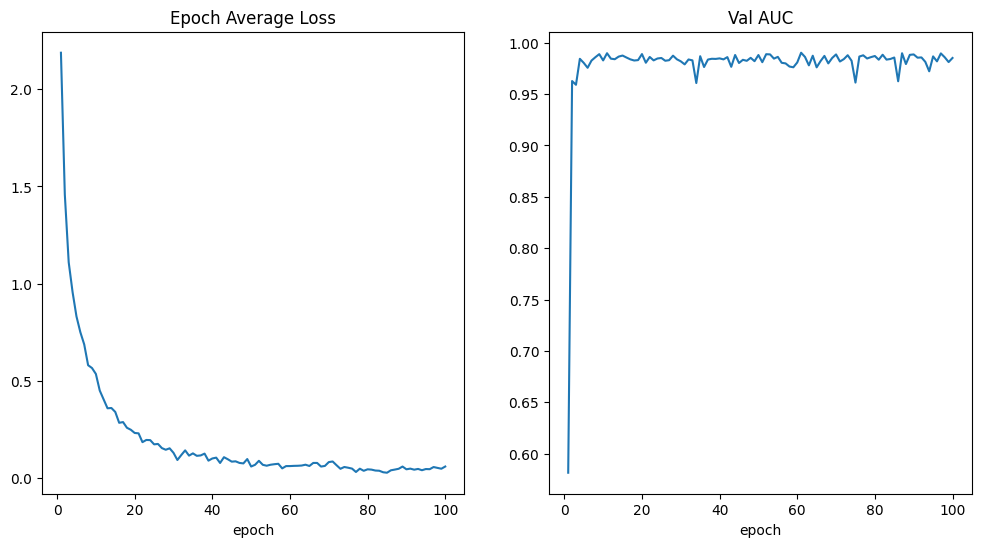

In [42]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [43]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [44]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8571    0.9565    0.9041        69
           1     0.4810    0.5588    0.5170        68
           2     0.5417    0.3768    0.4444        69
           3     0.5781    0.5692    0.5736        65
           4     0.5593    0.5077    0.5323        65
           5     0.8286    0.8788    0.8529        66
           6     0.8889    0.8571    0.8727        28
           7     0.8889    0.7619    0.8205        21
           8     0.7308    0.9048    0.8085        21
           9     0.7536    0.7536    0.7536        69
          10     0.7671    0.8116    0.7887        69

    accuracy                         0.6967       610
   macro avg     0.7159    0.7215    0.7153       610
weighted avg     0.6913    0.6967    0.6909       610



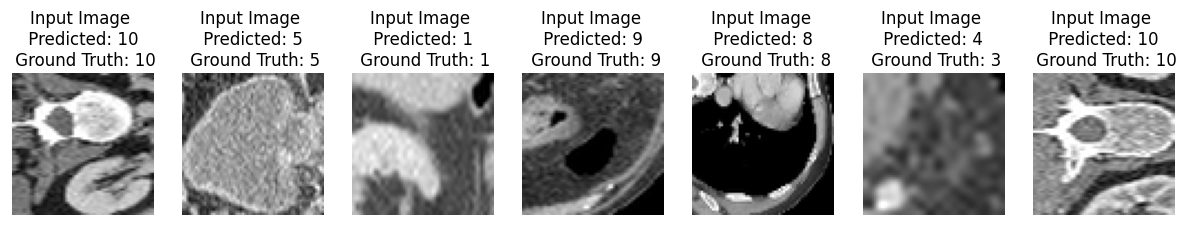

In [45]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_sagittal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [65]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 1.9966
1


Epochs:   1%|          | 1/100 [00:07<12:31,  7.59s/it]

saved new best metric model
current epoch: 1 current AUC: 0.4935 current accuracy: 0.0932 best AUC: 0.4935 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5315
1


Epochs:   2%|▏         | 2/100 [00:15<12:16,  7.52s/it]

saved new best metric model
current epoch: 2 current AUC: 0.7857 current accuracy: 0.2236 best AUC: 0.7857 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.2831
1


Epochs:   3%|▎         | 3/100 [00:22<12:11,  7.54s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9631 current accuracy: 0.6211 best AUC: 0.9631 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.1265


Epochs:   4%|▍         | 4/100 [00:29<11:52,  7.42s/it]

1
current epoch: 4 current AUC: 0.9498 current accuracy: 0.5217 best AUC: 0.9631 at epoch: 3
----------
epoch 5/100
epoch 5 average loss: 1.0177
1


Epochs:   5%|▌         | 5/100 [00:37<11:48,  7.46s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9674 current accuracy: 0.6335 best AUC: 0.9674 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.9427


Epochs:   6%|▌         | 6/100 [00:44<11:29,  7.34s/it]

1
current epoch: 6 current AUC: 0.9658 current accuracy: 0.5901 best AUC: 0.9674 at epoch: 5
----------
epoch 7/100
epoch 7 average loss: 0.8562
1


Epochs:   7%|▋         | 7/100 [00:52<11:31,  7.44s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9743 current accuracy: 0.6646 best AUC: 0.9743 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.7668
1


Epochs:   8%|▊         | 8/100 [00:59<11:28,  7.48s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9819 current accuracy: 0.7267 best AUC: 0.9819 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.7382


Epochs:   9%|▉         | 9/100 [01:06<11:11,  7.38s/it]

1
current epoch: 9 current AUC: 0.9791 current accuracy: 0.7453 best AUC: 0.9819 at epoch: 8
----------
epoch 10/100
epoch 10 average loss: 0.6757


Epochs:  10%|█         | 10/100 [01:14<10:57,  7.31s/it]

1
current epoch: 10 current AUC: 0.9803 current accuracy: 0.7019 best AUC: 0.9819 at epoch: 8
----------
epoch 11/100
epoch 11 average loss: 0.6235


Epochs:  11%|█         | 11/100 [01:21<10:46,  7.27s/it]

1
current epoch: 11 current AUC: 0.9800 current accuracy: 0.6894 best AUC: 0.9819 at epoch: 8
----------
epoch 12/100
epoch 12 average loss: 0.5557
1


Epochs:  12%|█▏        | 12/100 [01:28<10:47,  7.36s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9827 current accuracy: 0.7329 best AUC: 0.9827 at epoch: 12
----------
epoch 13/100
epoch 13 average loss: 0.5471


Epochs:  13%|█▎        | 13/100 [01:35<10:35,  7.31s/it]

1
current epoch: 13 current AUC: 0.9820 current accuracy: 0.7391 best AUC: 0.9827 at epoch: 12
----------
epoch 14/100
epoch 14 average loss: 0.5243


Epochs:  14%|█▍        | 14/100 [01:43<10:24,  7.26s/it]

1
current epoch: 14 current AUC: 0.9767 current accuracy: 0.6770 best AUC: 0.9827 at epoch: 12
----------
epoch 15/100
epoch 15 average loss: 0.4918


Epochs:  15%|█▌        | 15/100 [01:50<10:15,  7.25s/it]

1
current epoch: 15 current AUC: 0.9785 current accuracy: 0.7205 best AUC: 0.9827 at epoch: 12
----------
epoch 16/100
epoch 16 average loss: 0.4600


Epochs:  16%|█▌        | 16/100 [01:57<10:07,  7.23s/it]

1
current epoch: 16 current AUC: 0.9808 current accuracy: 0.7516 best AUC: 0.9827 at epoch: 12
----------
epoch 17/100
epoch 17 average loss: 0.4419


Epochs:  17%|█▋        | 17/100 [02:04<09:59,  7.22s/it]

1
current epoch: 17 current AUC: 0.9810 current accuracy: 0.7764 best AUC: 0.9827 at epoch: 12
----------
epoch 18/100
epoch 18 average loss: 0.4103
1


Epochs:  18%|█▊        | 18/100 [02:12<10:02,  7.34s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9873 current accuracy: 0.8075 best AUC: 0.9873 at epoch: 18
----------
epoch 19/100
epoch 19 average loss: 0.3669


Epochs:  19%|█▉        | 19/100 [02:19<09:51,  7.30s/it]

1
current epoch: 19 current AUC: 0.9818 current accuracy: 0.8012 best AUC: 0.9873 at epoch: 18
----------
epoch 20/100
epoch 20 average loss: 0.3739


Epochs:  20%|██        | 20/100 [02:26<09:40,  7.26s/it]

1
current epoch: 20 current AUC: 0.9854 current accuracy: 0.8261 best AUC: 0.9873 at epoch: 18
----------
epoch 21/100
epoch 21 average loss: 0.3520
1


Epochs:  21%|██        | 21/100 [02:34<09:41,  7.37s/it]

saved new best metric model
current epoch: 21 current AUC: 0.9900 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 21
----------
epoch 22/100
epoch 22 average loss: 0.3200


Epochs:  22%|██▏       | 22/100 [02:41<09:31,  7.33s/it]

1
current epoch: 22 current AUC: 0.9871 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 23/100
epoch 23 average loss: 0.3191


Epochs:  23%|██▎       | 23/100 [02:48<09:20,  7.28s/it]

1
current epoch: 23 current AUC: 0.9814 current accuracy: 0.7702 best AUC: 0.9900 at epoch: 21
----------
epoch 24/100
epoch 24 average loss: 0.2994


Epochs:  24%|██▍       | 24/100 [02:55<09:12,  7.27s/it]

1
current epoch: 24 current AUC: 0.9874 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 25/100
epoch 25 average loss: 0.2804


Epochs:  25%|██▌       | 25/100 [03:03<09:05,  7.27s/it]

1
current epoch: 25 current AUC: 0.9864 current accuracy: 0.7267 best AUC: 0.9900 at epoch: 21
----------
epoch 26/100
epoch 26 average loss: 0.2473


Epochs:  26%|██▌       | 26/100 [03:10<08:56,  7.25s/it]

1
current epoch: 26 current AUC: 0.9821 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 21
----------
epoch 27/100
epoch 27 average loss: 0.2607


Epochs:  27%|██▋       | 27/100 [03:17<08:42,  7.16s/it]

1
current epoch: 27 current AUC: 0.9776 current accuracy: 0.7640 best AUC: 0.9900 at epoch: 21
----------
epoch 28/100
epoch 28 average loss: 0.2350
1


Epochs:  28%|██▊       | 28/100 [03:24<08:26,  7.03s/it]

current epoch: 28 current AUC: 0.9849 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 21
----------
epoch 29/100
epoch 29 average loss: 0.2208
1


Epochs:  29%|██▉       | 29/100 [03:30<08:11,  6.92s/it]

current epoch: 29 current AUC: 0.9838 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 30/100
epoch 30 average loss: 0.2104


Epochs:  30%|███       | 30/100 [03:37<07:59,  6.85s/it]

1
current epoch: 30 current AUC: 0.9883 current accuracy: 0.8447 best AUC: 0.9900 at epoch: 21
----------
epoch 31/100
epoch 31 average loss: 0.2041


Epochs:  31%|███       | 31/100 [03:44<07:49,  6.80s/it]

1
current epoch: 31 current AUC: 0.9865 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 32/100
epoch 32 average loss: 0.2383
1


Epochs:  32%|███▏      | 32/100 [03:50<07:39,  6.76s/it]

current epoch: 32 current AUC: 0.9808 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 21
----------
epoch 33/100
epoch 33 average loss: 0.2016


Epochs:  33%|███▎      | 33/100 [03:57<07:31,  6.75s/it]

1
current epoch: 33 current AUC: 0.9799 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 21
----------
epoch 34/100
epoch 34 average loss: 0.2001
1


Epochs:  34%|███▍      | 34/100 [04:04<07:24,  6.74s/it]

current epoch: 34 current AUC: 0.9832 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 35/100
epoch 35 average loss: 0.1784


Epochs:  35%|███▌      | 35/100 [04:10<07:17,  6.74s/it]

1
current epoch: 35 current AUC: 0.9856 current accuracy: 0.7888 best AUC: 0.9900 at epoch: 21
----------
epoch 36/100
epoch 36 average loss: 0.1845
1


Epochs:  36%|███▌      | 36/100 [04:17<07:10,  6.73s/it]

current epoch: 36 current AUC: 0.9884 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 21
----------
epoch 37/100
epoch 37 average loss: 0.1822
1


Epochs:  37%|███▋      | 37/100 [04:24<07:04,  6.74s/it]

current epoch: 37 current AUC: 0.9838 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 21
----------
epoch 38/100
epoch 38 average loss: 0.1636


Epochs:  38%|███▊      | 38/100 [04:31<06:57,  6.74s/it]

1
current epoch: 38 current AUC: 0.9849 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 39/100
epoch 39 average loss: 0.1302
1


Epochs:  39%|███▉      | 39/100 [04:37<06:51,  6.74s/it]

current epoch: 39 current AUC: 0.9826 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 40/100
epoch 40 average loss: 0.1709


Epochs:  40%|████      | 40/100 [04:44<06:44,  6.74s/it]

1
current epoch: 40 current AUC: 0.9829 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 21
----------
epoch 41/100
epoch 41 average loss: 0.1626


Epochs:  41%|████      | 41/100 [04:51<06:37,  6.73s/it]

1
current epoch: 41 current AUC: 0.9796 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 21
----------
epoch 42/100
epoch 42 average loss: 0.1375


Epochs:  42%|████▏     | 42/100 [04:58<06:29,  6.72s/it]

1
current epoch: 42 current AUC: 0.9852 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 21
----------
epoch 43/100
epoch 43 average loss: 0.1411
1


Epochs:  43%|████▎     | 43/100 [05:04<06:22,  6.71s/it]

current epoch: 43 current AUC: 0.9890 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 21
----------
epoch 44/100
epoch 44 average loss: 0.1594
1


Epochs:  44%|████▍     | 44/100 [05:11<06:15,  6.70s/it]

current epoch: 44 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 21
----------
epoch 45/100
epoch 45 average loss: 0.1814
1


Epochs:  45%|████▌     | 45/100 [05:18<06:08,  6.70s/it]

current epoch: 45 current AUC: 0.9873 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 46/100
epoch 46 average loss: 0.1410
1


Epochs:  46%|████▌     | 46/100 [05:24<06:00,  6.68s/it]

current epoch: 46 current AUC: 0.9824 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 47/100
epoch 47 average loss: 0.1432


Epochs:  47%|████▋     | 47/100 [05:31<05:55,  6.71s/it]

1
current epoch: 47 current AUC: 0.9819 current accuracy: 0.7453 best AUC: 0.9900 at epoch: 21
----------
epoch 48/100
epoch 48 average loss: 0.1411


Epochs:  48%|████▊     | 48/100 [05:38<05:49,  6.72s/it]

1
current epoch: 48 current AUC: 0.9843 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 49/100
epoch 49 average loss: 0.1325
1


Epochs:  49%|████▉     | 49/100 [05:45<05:42,  6.72s/it]

current epoch: 49 current AUC: 0.9838 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 50/100
epoch 50 average loss: 0.1259


Epochs:  50%|█████     | 50/100 [05:51<05:36,  6.73s/it]

1
current epoch: 50 current AUC: 0.9846 current accuracy: 0.8075 best AUC: 0.9900 at epoch: 21
----------
epoch 51/100
epoch 51 average loss: 0.1460
1


Epochs:  51%|█████     | 51/100 [05:58<05:28,  6.71s/it]

current epoch: 51 current AUC: 0.9819 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 21
----------
epoch 52/100
epoch 52 average loss: 0.1125
1


Epochs:  52%|█████▏    | 52/100 [06:05<05:22,  6.71s/it]

current epoch: 52 current AUC: 0.9841 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 21
----------
epoch 53/100
epoch 53 average loss: 0.1201
1


Epochs:  53%|█████▎    | 53/100 [06:11<05:15,  6.71s/it]

current epoch: 53 current AUC: 0.9897 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 21
----------
epoch 54/100
epoch 54 average loss: 0.1204
1


Epochs:  54%|█████▍    | 54/100 [06:18<05:08,  6.70s/it]

current epoch: 54 current AUC: 0.9856 current accuracy: 0.7702 best AUC: 0.9900 at epoch: 21
----------
epoch 55/100
epoch 55 average loss: 0.1081
1


Epochs:  55%|█████▌    | 55/100 [06:25<05:02,  6.72s/it]

current epoch: 55 current AUC: 0.9826 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 56/100
epoch 56 average loss: 0.1252


Epochs:  56%|█████▌    | 56/100 [06:32<04:56,  6.73s/it]

1
current epoch: 56 current AUC: 0.9875 current accuracy: 0.7888 best AUC: 0.9900 at epoch: 21
----------
epoch 57/100
epoch 57 average loss: 0.0952
1


Epochs:  57%|█████▋    | 57/100 [06:38<04:48,  6.70s/it]

current epoch: 57 current AUC: 0.9898 current accuracy: 0.8447 best AUC: 0.9900 at epoch: 21
----------
epoch 58/100
epoch 58 average loss: 0.1404
1


Epochs:  58%|█████▊    | 58/100 [06:45<04:40,  6.67s/it]

current epoch: 58 current AUC: 0.9876 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 59/100
epoch 59 average loss: 0.0995


Epochs:  59%|█████▉    | 59/100 [06:51<04:33,  6.67s/it]

1
current epoch: 59 current AUC: 0.9845 current accuracy: 0.8075 best AUC: 0.9900 at epoch: 21
----------
epoch 60/100
epoch 60 average loss: 0.1267
1


Epochs:  60%|██████    | 60/100 [06:58<04:28,  6.70s/it]

current epoch: 60 current AUC: 0.9856 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 21
----------
epoch 61/100
epoch 61 average loss: 0.0896


Epochs:  61%|██████    | 61/100 [07:05<04:23,  6.75s/it]

1
current epoch: 61 current AUC: 0.9850 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 62/100
epoch 62 average loss: 0.0832


Epochs:  62%|██████▏   | 62/100 [07:12<04:21,  6.88s/it]

1
current epoch: 62 current AUC: 0.9884 current accuracy: 0.8323 best AUC: 0.9900 at epoch: 21
----------
epoch 63/100
epoch 63 average loss: 0.0783
1


Epochs:  63%|██████▎   | 63/100 [07:19<04:12,  6.83s/it]

current epoch: 63 current AUC: 0.9863 current accuracy: 0.7640 best AUC: 0.9900 at epoch: 21
----------
epoch 64/100
epoch 64 average loss: 0.0970
1


Epochs:  64%|██████▍   | 64/100 [07:26<04:04,  6.80s/it]

current epoch: 64 current AUC: 0.9852 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 21
----------
epoch 65/100
epoch 65 average loss: 0.1019
1


Epochs:  65%|██████▌   | 65/100 [07:32<03:56,  6.75s/it]

current epoch: 65 current AUC: 0.9818 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 21
----------
epoch 66/100
epoch 66 average loss: 0.0707
1


Epochs:  66%|██████▌   | 66/100 [07:39<03:48,  6.73s/it]

current epoch: 66 current AUC: 0.9859 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 21
----------
epoch 67/100
epoch 67 average loss: 0.0911
1


Epochs:  67%|██████▋   | 67/100 [07:46<03:41,  6.72s/it]

current epoch: 67 current AUC: 0.9860 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 21
----------
epoch 68/100
epoch 68 average loss: 0.1008
1


Epochs:  68%|██████▊   | 68/100 [07:52<03:34,  6.71s/it]

current epoch: 68 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 21
----------
epoch 69/100
epoch 69 average loss: 0.0972
1


Epochs:  69%|██████▉   | 69/100 [08:00<03:32,  6.84s/it]

saved new best metric model
current epoch: 69 current AUC: 0.9902 current accuracy: 0.8447 best AUC: 0.9902 at epoch: 69
----------
epoch 70/100
epoch 70 average loss: 0.0749
1


Epochs:  70%|███████   | 70/100 [08:07<03:28,  6.94s/it]

saved new best metric model
current epoch: 70 current AUC: 0.9913 current accuracy: 0.8696 best AUC: 0.9913 at epoch: 70
----------
epoch 71/100
epoch 71 average loss: 0.0792


Epochs:  71%|███████   | 71/100 [08:13<03:18,  6.84s/it]

1
current epoch: 71 current AUC: 0.9901 current accuracy: 0.8758 best AUC: 0.9913 at epoch: 70
----------
epoch 72/100
epoch 72 average loss: 0.1095


Epochs:  72%|███████▏  | 72/100 [08:20<03:10,  6.82s/it]

1
current epoch: 72 current AUC: 0.9814 current accuracy: 0.7950 best AUC: 0.9913 at epoch: 70
----------
epoch 73/100
epoch 73 average loss: 0.0739
1


Epochs:  73%|███████▎  | 73/100 [08:27<03:02,  6.76s/it]

current epoch: 73 current AUC: 0.9860 current accuracy: 0.8261 best AUC: 0.9913 at epoch: 70
----------
epoch 74/100
epoch 74 average loss: 0.0666
1


Epochs:  74%|███████▍  | 74/100 [08:33<02:55,  6.74s/it]

current epoch: 74 current AUC: 0.9861 current accuracy: 0.8137 best AUC: 0.9913 at epoch: 70
----------
epoch 75/100
epoch 75 average loss: 0.0763
1


Epochs:  75%|███████▌  | 75/100 [08:40<02:48,  6.72s/it]

current epoch: 75 current AUC: 0.9861 current accuracy: 0.8261 best AUC: 0.9913 at epoch: 70
----------
epoch 76/100
epoch 76 average loss: 0.0748


Epochs:  76%|███████▌  | 76/100 [08:47<02:41,  6.71s/it]

1
current epoch: 76 current AUC: 0.9860 current accuracy: 0.8261 best AUC: 0.9913 at epoch: 70
----------
epoch 77/100
epoch 77 average loss: 0.0822
1


Epochs:  77%|███████▋  | 77/100 [08:53<02:33,  6.68s/it]

current epoch: 77 current AUC: 0.9852 current accuracy: 0.8137 best AUC: 0.9913 at epoch: 70
----------
epoch 78/100
epoch 78 average loss: 0.0803
1


Epochs:  78%|███████▊  | 78/100 [09:00<02:27,  6.70s/it]

current epoch: 78 current AUC: 0.9909 current accuracy: 0.8323 best AUC: 0.9913 at epoch: 70
----------
epoch 79/100
epoch 79 average loss: 0.0687
1


Epochs:  79%|███████▉  | 79/100 [09:07<02:21,  6.73s/it]

current epoch: 79 current AUC: 0.9895 current accuracy: 0.8758 best AUC: 0.9913 at epoch: 70
----------
epoch 80/100
epoch 80 average loss: 0.0653
1


Epochs:  80%|████████  | 80/100 [09:14<02:14,  6.71s/it]

current epoch: 80 current AUC: 0.9852 current accuracy: 0.7702 best AUC: 0.9913 at epoch: 70
----------
epoch 81/100
epoch 81 average loss: 0.0806
1


Epochs:  81%|████████  | 81/100 [09:20<02:07,  6.69s/it]

current epoch: 81 current AUC: 0.9880 current accuracy: 0.8634 best AUC: 0.9913 at epoch: 70
----------
epoch 82/100
epoch 82 average loss: 0.0935
1


Epochs:  82%|████████▏ | 82/100 [09:27<02:00,  6.68s/it]

current epoch: 82 current AUC: 0.9877 current accuracy: 0.8447 best AUC: 0.9913 at epoch: 70
----------
epoch 83/100
epoch 83 average loss: 0.0926
1


Epochs:  83%|████████▎ | 83/100 [09:34<01:53,  6.68s/it]

current epoch: 83 current AUC: 0.9893 current accuracy: 0.8447 best AUC: 0.9913 at epoch: 70
----------
epoch 84/100
epoch 84 average loss: 0.0667
1


Epochs:  84%|████████▍ | 84/100 [09:41<01:49,  6.82s/it]

saved new best metric model
current epoch: 84 current AUC: 0.9923 current accuracy: 0.8758 best AUC: 0.9923 at epoch: 84
----------
epoch 85/100
epoch 85 average loss: 0.0566
1


Epochs:  85%|████████▌ | 85/100 [09:47<01:41,  6.77s/it]

current epoch: 85 current AUC: 0.9831 current accuracy: 0.8261 best AUC: 0.9923 at epoch: 84
----------
epoch 86/100
epoch 86 average loss: 0.1090
1


Epochs:  86%|████████▌ | 86/100 [09:54<01:34,  6.78s/it]

current epoch: 86 current AUC: 0.9845 current accuracy: 0.8012 best AUC: 0.9923 at epoch: 84
----------
epoch 87/100
epoch 87 average loss: 0.0924
1


Epochs:  87%|████████▋ | 87/100 [10:01<01:27,  6.77s/it]

current epoch: 87 current AUC: 0.9867 current accuracy: 0.7826 best AUC: 0.9923 at epoch: 84
----------
epoch 88/100
epoch 88 average loss: 0.0877


Epochs:  88%|████████▊ | 88/100 [10:08<01:21,  6.77s/it]

1
current epoch: 88 current AUC: 0.9853 current accuracy: 0.7702 best AUC: 0.9923 at epoch: 84
----------
epoch 89/100
epoch 89 average loss: 0.0922
1


Epochs:  89%|████████▉ | 89/100 [10:14<01:14,  6.75s/it]

current epoch: 89 current AUC: 0.9850 current accuracy: 0.8199 best AUC: 0.9923 at epoch: 84
----------
epoch 90/100
epoch 90 average loss: 0.0846
1


Epochs:  90%|█████████ | 90/100 [10:21<01:07,  6.74s/it]

current epoch: 90 current AUC: 0.9876 current accuracy: 0.8571 best AUC: 0.9923 at epoch: 84
----------
epoch 91/100
epoch 91 average loss: 0.0818
1


Epochs:  91%|█████████ | 91/100 [10:28<01:00,  6.73s/it]

current epoch: 91 current AUC: 0.9857 current accuracy: 0.8509 best AUC: 0.9923 at epoch: 84
----------
epoch 92/100
epoch 92 average loss: 0.0664
1


Epochs:  92%|█████████▏| 92/100 [10:35<00:53,  6.73s/it]

current epoch: 92 current AUC: 0.9852 current accuracy: 0.8447 best AUC: 0.9923 at epoch: 84
----------
epoch 93/100
epoch 93 average loss: 0.0651
1


Epochs:  93%|█████████▎| 93/100 [10:42<00:47,  6.85s/it]

saved new best metric model
current epoch: 93 current AUC: 0.9936 current accuracy: 0.8385 best AUC: 0.9936 at epoch: 93
----------
epoch 94/100
epoch 94 average loss: 0.0847
1


Epochs:  94%|█████████▍| 94/100 [10:48<00:40,  6.80s/it]

current epoch: 94 current AUC: 0.9896 current accuracy: 0.8447 best AUC: 0.9936 at epoch: 93
----------
epoch 95/100
epoch 95 average loss: 0.0700
1


Epochs:  95%|█████████▌| 95/100 [10:55<00:33,  6.75s/it]

current epoch: 95 current AUC: 0.9890 current accuracy: 0.8261 best AUC: 0.9936 at epoch: 93
----------
epoch 96/100
epoch 96 average loss: 0.0701
1


Epochs:  96%|█████████▌| 96/100 [11:02<00:26,  6.72s/it]

current epoch: 96 current AUC: 0.9899 current accuracy: 0.8385 best AUC: 0.9936 at epoch: 93
----------
epoch 97/100
epoch 97 average loss: 0.0559
1


Epochs:  97%|█████████▋| 97/100 [11:08<00:20,  6.72s/it]

current epoch: 97 current AUC: 0.9896 current accuracy: 0.8634 best AUC: 0.9936 at epoch: 93
----------
epoch 98/100
epoch 98 average loss: 0.0617
1


Epochs:  98%|█████████▊| 98/100 [11:15<00:13,  6.72s/it]

current epoch: 98 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9936 at epoch: 93
----------
epoch 99/100
epoch 99 average loss: 0.0731
1


Epochs:  99%|█████████▉| 99/100 [11:22<00:06,  6.72s/it]

current epoch: 99 current AUC: 0.9925 current accuracy: 0.8758 best AUC: 0.9936 at epoch: 93
----------
epoch 100/100
epoch 100 average loss: 0.0774
1


Epochs: 100%|██████████| 100/100 [11:28<00:00,  6.89s/it]

current epoch: 100 current AUC: 0.9859 current accuracy: 0.8385 best AUC: 0.9936 at epoch: 93
train completed, best_metric: 0.9936 at epoch: 93


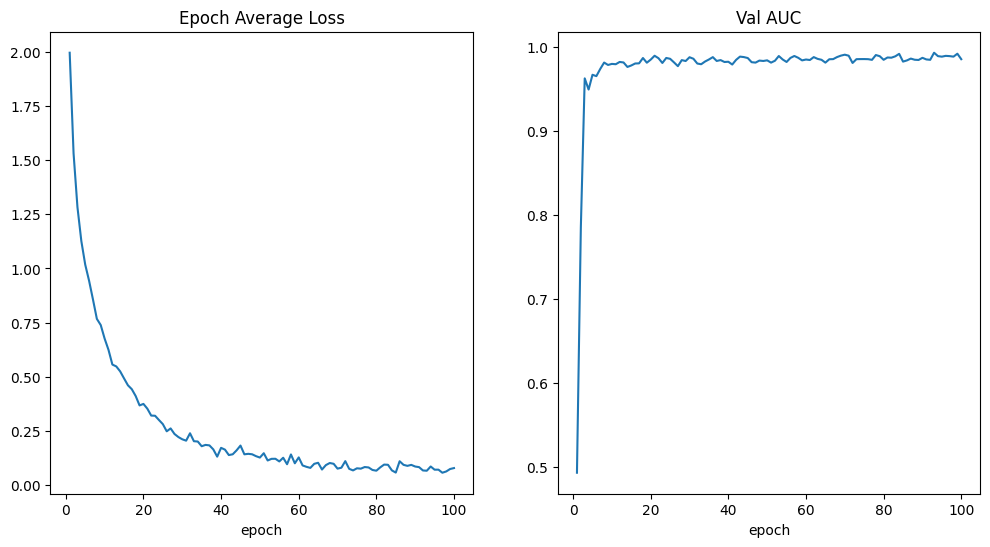

In [66]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [67]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [68]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.7097    0.3188    0.4400        69
           1     0.2449    0.1765    0.2051        68
           2     0.2078    0.2319    0.2192        69
           3     0.5098    0.4000    0.4483        65
           4     0.4348    0.1538    0.2273        65
           5     0.5758    0.5758    0.5758        66
           6     0.4545    0.1786    0.2564        28
           7     0.4783    0.5238    0.5000        21
           8     0.0000    0.0000    0.0000        21
           9     0.3776    0.5362    0.4431        69
          10     0.2570    0.6667    0.3710        69

    accuracy                         0.3656       610
   macro avg     0.3864    0.3420    0.3351       610
weighted avg     0.4031    0.3656    0.3528       610



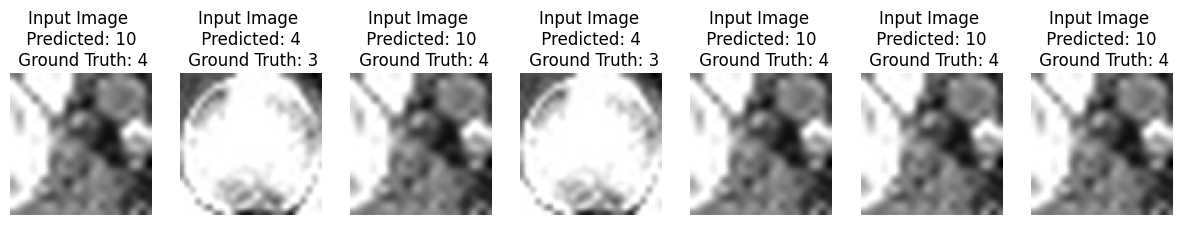

In [69]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## 3D slices evaluation

In [47]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, slices=9, transform=None):
        self.dataset = dataset
        self.slices = slices
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        slices = self.slices

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data, slices)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data, slices):
        dims = data.shape
        axial, coronal, sagittal = [], [], []
        middle_idx = [dims[i] // 2 for i in range(0, 4)]
        
        for d in range(3):
            start_idx = middle_idx[d] - slices // 2  # Start 4 slices before the middle
            end_idx = middle_idx[d] + slices // 2 + 1    # End 4 slices after the middle
            
            for i in range(start_idx, end_idx):
                if d == 0:
                    axial.append(data[:, i, :, :])
                elif d == 1:
                    coronal.append(data[:, :, i, :])
                elif d == 2:
                    sagittal.append(data[:, :, :, i])
        
        return axial, coronal, sagittal

In [48]:
train_dataset_ = Sliced_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = Sliced_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = Sliced_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Pretrained

In [62]:
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_axial.eval()

model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_coronal.eval()

model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model_sagittal.eval()

results = []

for num_slices in range(5, 25):  # Adjust the range based on your requirements
    y_true = []
    y_pred = []

    train_dataset_ = Sliced_Dataset(train_dataset, slices=num_slices, transform=train_transforms)
    val_dataset_ = Sliced_Dataset(val_dataset, slices=num_slices, transform=val_transforms)
    test_dataset_ = Sliced_Dataset(test_dataset, slices=num_slices, transform=test_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data['images'],
                test_data['label'][:, 0].type(torch.LongTensor).to(device),
            )
            test_axial, test_coronal, test_sagittal = test_images
            for i in range(num_slices):
                pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
                pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
                pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
                if i != 0:
                    pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
                else:
                    pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
            
            for i in range(pred.shape[1]):
                data = pred[:, i]
                counts = torch.bincount(data)
                most_frequent_value = torch.argmax(counts).item()
                
                y_true.append(test_labels[i].item())
                y_pred.append(most_frequent_value)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    selected_metrics = {
        "num_slices": num_slices,
        "accuracy": report["accuracy"],
    }
    results.append(selected_metrics)

# Combine all results into a single DataFrame
final_results = pd.DataFrame(results, index = None)

# Save to CSV or analyze further
final_results.to_csv("classification_results_pretrained.csv", index=False)
print(final_results)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


    num_slices  accuracy
0            5  0.649180
1            6  0.659016
2            7  0.657377
3            8  0.663934
4            9  0.662295
5           10  0.673770
6           11  0.678689
7           12  0.675410
8           13  0.681967
9           14  0.686885
10          15  0.681967
11          16  0.688525
12          17  0.690164
13          18  0.690164
14          19  0.693443
15          20  0.688525
16          21  0.688525
17          22  0.685246
18          23  0.688525
19          24  0.691803


## Unpretrained

In [63]:
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_axial.eval()
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_coronal.eval()
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model_sagittal.eval()

results = []

for num_slices in range(5, 25):  # Adjust the range based on your requirements
    y_true = []
    y_pred = []

    train_dataset_ = Sliced_Dataset(train_dataset, slices=num_slices, transform=train_transforms)
    val_dataset_ = Sliced_Dataset(val_dataset, slices=num_slices, transform=val_transforms)
    test_dataset_ = Sliced_Dataset(test_dataset, slices=num_slices, transform=test_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data['images'],
                test_data['label'][:, 0].type(torch.LongTensor).to(device),
            )
            test_axial, test_coronal, test_sagittal = test_images
            for i in range(num_slices):
                pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
                pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
                pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
                if i != 0:
                    pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
                else:
                    pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
            
            for i in range(pred.shape[1]):
                data = pred[:, i]
                counts = torch.bincount(data)
                most_frequent_value = torch.argmax(counts).item()
                
                y_true.append(test_labels[i].item())
                y_pred.append(most_frequent_value)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    selected_metrics = {
        "num_slices": num_slices,
        "accuracy": report["accuracy"],
    }
    results.append(selected_metrics)
    
# Combine all results into a single DataFrame
final_results = pd.DataFrame(results)

# Save to CSV or analyze further
final_results.to_csv("classification_results_unpretrained.csv", index=False)
print(final_results)

    num_slices  accuracy
0            5  0.744262
1            6  0.749180
2            7  0.745902
3            8  0.744262
4            9  0.747541
5           10  0.755738
6           11  0.762295
7           12  0.760656
8           13  0.762295
9           14  0.760656
10          15  0.757377
11          16  0.757377
12          17  0.763934
13          18  0.763934
14          19  0.775410
15          20  0.768852
16          21  0.775410
17          22  0.770492
18          23  0.772131
19          24  0.770492


# Using 2d models as a backbone

In [23]:
class CombinedResNetModel(nn.Module):
    def __init__(self, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()

        # Initialize 2D ResNet models (without pre-trained weights and final layers)
        self.model_axial = nn.Sequential(*list(nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).children())[:-1])
        self.model_coronal = nn.Sequential(*list(nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).children())[:-1])
        self.model_sagittal = nn.Sequential(*list(nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).children())[:-1])

        # Assuming each ResNet outputs a 512-dimension feature vector (for ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions

        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        # Extract slices from the input tensor (3D volumes)
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Pass slices through respective ResNet feature extractors
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

In [24]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

combined_model = CombinedResNetModel(num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [53]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 0.9120297778037286
Epoch 2, Loss: 0.9118739847213991
Epoch 3, Loss: 0.8910253278670772
Epoch 4, Loss: 0.9085988517730467
Epoch 5, Loss: 0.8925570537967067
Epoch 6, Loss: 0.8925534602134458
Epoch 7, Loss: 0.8784077821239349
Epoch 8, Loss: 0.884802887516637
Epoch 9, Loss: 0.8663209619060639
Epoch 10, Loss: 0.9017090009104821
Epoch 11, Loss: 0.8758883437802715
Epoch 12, Loss: 0.8726311249117698
Epoch 13, Loss: 0.8820331865741361
Epoch 14, Loss: 0.8817436637416962
Epoch 15, Loss: 0.8699092615035272
Epoch 16, Loss: 0.8710375466654378
Epoch 17, Loss: 0.8705649722007013
Epoch 18, Loss: 0.8581481095283262
Epoch 19, Loss: 0.8911111297145966
Epoch 20, Loss: 0.8307212418125521
Epoch 21, Loss: 0.8803435256404262
Epoch 22, Loss: 0.8706283107880624
Epoch 23, Loss: 0.8680743921187616
Epoch 24, Loss: 0.8672022992564786
Epoch 25, Loss: 0.8414758366923178
Epoch 26, Loss: 0.8630079146354429
Epoch 27, Loss: 0.831877218138787
Epoch 28, Loss: 0.8452523389170247
Epoch 29, Loss: 0.8639885379422

In [54]:
auc_metric = ROCAUCMetric()

In [55]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9848, Accuracy: 14.8509


In [56]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [57]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.7361    0.7681    0.7518        69
           1     0.7174    0.4853    0.5789        68
           2     0.5395    0.5942    0.5655        69
           3     0.7903    0.7538    0.7717        65
           4     0.7414    0.6615    0.6992        65
           5     0.6667    0.7576    0.7092        66
           6     1.0000    0.5714    0.7273        28
           7     0.8696    0.9524    0.9091        21
           8     1.0000    0.7143    0.8333        21
           9     0.5455    0.6087    0.5753        69
          10     0.6000    0.7826    0.6792        69

    accuracy                         0.6820       610
   macro avg     0.7460    0.6955    0.7091       610
weighted avg     0.6994    0.6820    0.6823       610



In [94]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [95]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [96]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [97]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [98]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.2312430912448513
Epoch 2, Loss: 1.421457217585656
Epoch 3, Loss: 0.922661877447559
Epoch 4, Loss: 0.6472801921829101
Epoch 5, Loss: 0.45579215595799105
Epoch 6, Loss: 0.3697362450822707
Epoch 7, Loss: 0.2796674947584829
Epoch 8, Loss: 0.24498080534319724
Epoch 9, Loss: 0.21896092834011202
Epoch 10, Loss: 0.1828131980953678
Epoch 11, Loss: 0.16094289239375822
Epoch 12, Loss: 0.14291496839254134
Epoch 13, Loss: 0.1332861322068399
Epoch 14, Loss: 0.12199729993458718
Epoch 15, Loss: 0.11563054496242155
Epoch 16, Loss: 0.10485555928560995
Epoch 17, Loss: 0.10262967754275568
Epoch 18, Loss: 0.09630265062855135
Epoch 19, Loss: 0.08798556089881927
Epoch 20, Loss: 0.0789409639133561
Epoch 21, Loss: 0.07574334302015844
Epoch 22, Loss: 0.07293778381520702
Epoch 23, Loss: 0.0698364801224201
Epoch 24, Loss: 0.06811184351963381
Epoch 25, Loss: 0.06529827656284455
Epoch 26, Loss: 0.06125469535829559
Epoch 27, Loss: 0.05333068347986667
Epoch 28, Loss: 0.0587595610488807
Epoch 29, Loss

In [99]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9973, Accuracy: 14.7019


In [100]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [101]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9855    0.9645        69
           1     0.6250    0.6618    0.6429        68
           2     0.6250    0.5072    0.5600        69
           3     0.5802    0.7231    0.6438        65
           4     0.5893    0.5077    0.5455        65
           5     0.9833    0.8939    0.9365        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.9524    0.9756        21
           8     0.9545    1.0000    0.9767        21
           9     0.8923    0.8406    0.8657        69
          10     0.8148    0.9565    0.8800        69

    accuracy                         0.7820       610
   macro avg     0.8190    0.8111    0.8122       610
weighted avg     0.7845    0.7820    0.7801       610



## Pretrained

In [102]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [103]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [104]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [105]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.209972116254991
Epoch 2, Loss: 1.5391398437561528
Epoch 3, Loss: 1.106486028240573
Epoch 4, Loss: 0.8300667808901879
Epoch 5, Loss: 0.6515264991791018
Epoch 6, Loss: 0.5372383815626944
Epoch 7, Loss: 0.45590533364203667
Epoch 8, Loss: 0.3755879238728554
Epoch 9, Loss: 0.35382200392984575
Epoch 10, Loss: 0.28915675417069464
Epoch 11, Loss: 0.2718480714867192
Epoch 12, Loss: 0.2541493367283575
Epoch 13, Loss: 0.22152516101637193
Epoch 14, Loss: 0.20836776134467894
Epoch 15, Loss: 0.18629736933977373
Epoch 16, Loss: 0.16857336725919478
Epoch 17, Loss: 0.15773695947662478
Epoch 18, Loss: 0.14726027125312435
Epoch 19, Loss: 0.14188698583072232
Epoch 20, Loss: 0.12650460437420877
Epoch 21, Loss: 0.12512190880313998
Epoch 22, Loss: 0.1142291289664084
Epoch 23, Loss: 0.1082615751412607
Epoch 24, Loss: 0.10035355317015801
Epoch 25, Loss: 0.10530646181394977
Epoch 26, Loss: 0.09537249022433834
Epoch 27, Loss: 0.10398807604947398
Epoch 28, Loss: 0.09979269533388076
Epoch 29, Loss

In [106]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9975, Accuracy: 14.6708


In [107]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [108]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9286    0.9420    0.9353        69
           1     0.5714    0.6471    0.6069        68
           2     0.5231    0.4928    0.5075        69
           3     0.6081    0.6923    0.6475        65
           4     0.6604    0.5385    0.5932        65
           5     0.9118    0.9394    0.9254        66
           6     1.0000    0.9286    0.9630        28
           7     0.9048    0.9048    0.9048        21
           8     0.8696    0.9524    0.9091        21
           9     0.8793    0.7391    0.8031        69
          10     0.8533    0.9275    0.8889        69

    accuracy                         0.7623       610
   macro avg     0.7918    0.7913    0.7895       610
weighted avg     0.7647    0.7623    0.7612       610



## Hyper network

In [109]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [110]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [111]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [112]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1992361584017353
Epoch 2, Loss: 1.7598386080034318
Epoch 3, Loss: 1.4035456372845558
Epoch 4, Loss: 1.1226484294860595
Epoch 5, Loss: 0.8967698004937941
Epoch 6, Loss: 0.7375160667204088
Epoch 7, Loss: 0.6257494784170582
Epoch 8, Loss: 0.538525979365072
Epoch 9, Loss: 0.4689262730460013
Epoch 10, Loss: 0.41023298136649594
Epoch 11, Loss: 0.3654448832235029
Epoch 12, Loss: 0.31974188454689517
Epoch 13, Loss: 0.29247157227608467
Epoch 14, Loss: 0.2750833462322912
Epoch 15, Loss: 0.2367192876915778
Epoch 16, Loss: 0.22779082242519624
Epoch 17, Loss: 0.2001585167261862
Epoch 18, Loss: 0.19408177896853415
Epoch 19, Loss: 0.18026458832525438
Epoch 20, Loss: 0.17006470118799516
Epoch 21, Loss: 0.16055732124274777
Epoch 22, Loss: 0.1524661344385916
Epoch 23, Loss: 0.15138765640797153
Epoch 24, Loss: 0.1312374520686365
Epoch 25, Loss: 0.1263259990561393
Epoch 26, Loss: 0.12087722723522494
Epoch 27, Loss: 0.1171155646443367
Epoch 28, Loss: 0.10788286261020168
Epoch 29, Loss: 0.1

In [113]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9971, Accuracy: 14.7205


In [114]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [115]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9855    0.9714        69
           1     0.6029    0.6029    0.6029        68
           2     0.6034    0.5072    0.5512        69
           3     0.5694    0.6308    0.5985        65
           4     0.5455    0.5538    0.5496        65
           5     0.9531    0.9242    0.9385        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8806    0.8551    0.8676        69
          10     0.8442    0.9420    0.8904        69

    accuracy                         0.7754       610
   macro avg     0.8143    0.8086    0.8103       610
weighted avg     0.7756    0.7754    0.7743       610



## Pretrained

In [116]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [117]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [118]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.320294141769409
Epoch 2, Loss: 1.9302975093164751
Epoch 3, Loss: 1.6248393251049904
Epoch 4, Loss: 1.3602186402966898
Epoch 5, Loss: 1.1579040231243256
Epoch 6, Loss: 0.9927879629596588
Epoch 7, Loss: 0.8538400684633562
Epoch 8, Loss: 0.753643274307251
Epoch 9, Loss: 0.6752755690005517
Epoch 10, Loss: 0.5904088914394379
Epoch 11, Loss: 0.5181801924782414
Epoch 12, Loss: 0.4749601829436518
Epoch 13, Loss: 0.4294242060953571
Epoch 14, Loss: 0.4072332093792577
Epoch 15, Loss: 0.3804048155584643
Epoch 16, Loss: 0.3454054959358708
Epoch 17, Loss: 0.3166822521917282
Epoch 18, Loss: 0.2991942835430945
Epoch 19, Loss: 0.2910392245938701
Epoch 20, Loss: 0.25321460587363087
Epoch 21, Loss: 0.23840012281171738
Epoch 22, Loss: 0.24003998839086102
Epoch 23, Loss: 0.22250783876065286
Epoch 24, Loss: 0.21975779725659278
Epoch 25, Loss: 0.1920144687737188
Epoch 26, Loss: 0.1949321769418255
Epoch 27, Loss: 0.18407361113256024
Epoch 28, Loss: 0.1788940179732538
Epoch 29, Loss: 0.1644312

In [119]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9941, Accuracy: 14.7143


In [120]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [121]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9306    0.9710    0.9504        69
           1     0.6027    0.6471    0.6241        68
           2     0.5968    0.5362    0.5649        69
           3     0.6282    0.7538    0.6853        65
           4     0.7292    0.5385    0.6195        65
           5     0.8333    0.9091    0.8696        66
           6     1.0000    0.8571    0.9231        28
           7     0.9500    0.9048    0.9268        21
           8     0.8696    0.9524    0.9091        21
           9     0.8358    0.8116    0.8235        69
          10     0.9014    0.9275    0.9143        69

    accuracy                         0.7787       610
   macro avg     0.8071    0.8008    0.8010       610
weighted avg     0.7798    0.7787    0.7762       610

